# Quiz (Week 4): 
Using Opentrons and active learning to produce a color of choice. 
The color should be the last 3 digits of your student ID. Each student contribute to 1 channel of R, G, B. 

Submit your homework with Name and student ID to the github repo


In [ ]:
Ramachandran Rohan (U2223933K)
Kee Yi Long (U2322569K)

# 1. Connecting to Opentrons (0 points, no mark)

In [ ]:
#Setup & Check Robot Connectivity
#from opentrons import protocol_api
import requests

ROBOT_IP = "169.254.91.213"  # Replace with your robot's IP address, 169.254.91.213
BASE_URL = f"http://{ROBOT_IP}:31950"
HEADERS = {"Opentrons-Version": "*"}

try:
    response = requests.get(f"{BASE_URL}/health", headers=HEADERS, timeout=5)
    if response.ok:
        print("BEARS Robot is healthy:", response.json())
    else:
        print("Failed to connect to the robot. Status code:", response.status_code)
except requests.exceptions.RequestException as e:
    print("Error connecting to the robot:", e)


# 2. Construct a color mixing protocol to innitiate active learning (40 points)

A. Please generate a few starting point (colors) and a target color.  
B. Prepare them using Opentrons protocol.  
C. Capture an image.  
D. aquire respective ROIs.  

### Please construct your own control protocol and submit as an attachment. 

In [4]:
import requests

protocol_file_path = "New_Q2_protocol.py"  # Replace with your protocol file path

with open(protocol_file_path, 'rb') as file:
    files = {'files': (protocol_file_path, file)}
    response = requests.post(f"{BASE_URL}/protocols", headers=HEADERS, files=files)

if response.ok:
    protocol_id = response.json()["data"]["id"]
    print("Protocol uploaded successfully. Protocol ID:", protocol_id)
else:
    print("Failed to upload protocol. Status code:", response.status_code)
    print("Response:", response.text)

Protocol uploaded successfully. Protocol ID: 0f7cc5bf-681c-4ec5-b60f-3ed70798dcd2


In [ ]:
# Create a new run
run_response = requests.post(f"{BASE_URL}/runs", headers=HEADERS, json={"data": {"protocolId": protocol_id}})
if run_response.ok:
    run_id = run_response.json()["data"]["id"]
    print("Run created successfully. ID:", run_id)
else:
    print("Failed to create run. Status code:", run_response.status_code)
    print("Response:", run_response.text)

# Start the run
start_response = requests.post(f"{BASE_URL}/runs/{run_id}/actions", headers=HEADERS, json={"data": {"actionType": "play"}})
if start_response.ok:
    print("Run started successfully.")
else:
    print("Failed to start run. Status code:", start_response.status_code)
    print("Response:", start_response.text)

In [5]:
# Image Processing Functions
import os
import json
import numpy as np
from PIL import Image

def capture_image(BASE_URL, HEADERS, filename="captured_image.jpg"):
    """Capture image from robot camera"""
    resp = requests.post(f"{BASE_URL}/camera/picture", headers=HEADERS)
    if resp.ok:
        with open(filename, "wb") as f:
            f.write(resp.content)
        print(f"📸 Image saved: {filename}")
        return filename
    else:
        print("❌ Failed to capture image.")
        return None

def crop_plate(image_path, out_path="cropped.jpg", crop_box=(430, 15, 610, 150)):
    """Crop plate region from full camera image"""
    image = Image.open(image_path).convert("RGB")
    cropped = image.crop(crop_box)
    cropped.save(out_path)
    print(f"🟩 Cropped image saved: {out_path}")
    pix = np.array(cropped)
    return cropped, pix

def slice_rois(pix, rows=8, cols=12, offset=((5, 6), (6, 7))):
    """Slice plate image into individual well ROIs"""
    h, w, _ = pix.shape
    dh, dw = h // rows, w // cols
    rois = []
    for r in range(rows):
        for c in range(cols):
            y1 = r*dh + offset[1][0]
            y2 = (r+1)*dh - offset[1][1]
            x1 = c*dw + offset[0][0]
            x2 = (c+1)*dw - offset[0][1]
            rois.append(pix[y1:y2, x1:x2])
    return rois

def save_rois_and_metadata(rois, base_image_id, metadata, base_dir="output"):
    """Save individual ROI images and metadata"""
    os.makedirs(base_dir, exist_ok=True)
    img_dir = os.path.join(base_dir, f"dispense_{base_image_id}")
    os.makedirs(img_dir, exist_ok=True)

    meta_path = os.path.join(img_dir, "metadata.json")
    with open(meta_path, "w") as f:
        json.dump(metadata, f, indent=2)

    for i, roi in enumerate(rois):
        img = Image.fromarray(roi.astype(np.uint8))
        roi_path = os.path.join(img_dir, f"roi_{i+1:02d}.jpg")
        img.save(roi_path)
    
    npy_path = os.path.join(img_dir, "rois.npy")
    np.save(npy_path, rois)

    print(f"🧬 Saved {len(rois)} ROIs to: {img_dir}")


In [6]:

# Monitor protocol status and capture images
import requests
import time

seen_command_ids = set()
last_dispense_cmd = None

while True:
    # --- get run status ---
    run_resp = requests.get(f"{BASE_URL}/runs/{run_id}", headers=HEADERS)
    if not run_resp.ok:
        print("Failed to get run status:", run_resp.status_code)
        break

    status = run_resp.json()["data"]["status"]
    print("Current run status:", status)

    # --- get new commands ---
    cmd_resp = requests.get(f"{BASE_URL}/runs/{run_id}/commands", headers=HEADERS)
    if not cmd_resp.ok:
        print("Failed to get commands:", cmd_resp.status_code)
        break

    for cmd in cmd_resp.json()["data"]:
        cid = cmd["id"]
        if cid in seen_command_ids:
            continue
        seen_command_ids.add(cid)

        ctype = cmd.get("commandType", "")
        params = cmd.get("params", {})
        volume = params.get("volume")
        location = params.get("labware") or params.get("well")

        if ctype in ("aspirate", "dispense") and volume is not None:
            print(f"🔄 {ctype.capitalize()}  Volume: {volume} µL  |  Location: {location}")

            if ctype == "dispense":
                last_dispense_cmd = {
                    "id": cid,
                    "volume": volume,
                    "location": location
                }

    # --- exit when run finishes ---
    if status in ("succeeded", "failed", "stopped"):
        print(f"✅ Protocol {status}.")
        break

    time.sleep(5)

# --- process only the last dispense image ---
if last_dispense_cmd:
    cid = last_dispense_cmd["id"]
    volume = last_dispense_cmd["volume"]
    location = last_dispense_cmd["location"]
    print(f"\n📌 Capturing only the last dispense (ID: {cid})")

    raw_name = f"dispense_image.jpg"
    img_path = capture_image(BASE_URL, HEADERS, filename=raw_name)

    if img_path:
        # Proceed with image correction + cropping
        # First, process the captured image
        cropped_image, pix = crop_plate(img_path, out_path="cropped_dispense.jpg")
        
        # Now extract ROIs from the processed image
        rois = slice_rois(pix)

        save_rois_and_metadata(
            rois=rois,
            base_image_id=cid,
            metadata={"volume": volume, "location": location}
        )

time.sleep (5)


NameError: name 'run_id' is not defined

In [22]:
# Capture reference image
image_response = requests.post(f"{BASE_URL}/camera/picture", headers=HEADERS)
if image_response.ok:
    with open("captured_image.jpg", "wb") as f:
        f.write(image_response.content)
    print("Image captured and saved as 'captured_image.jpg'.")
else:
    print("Failed to capture image. Status code:", image_response.status_code)
    print("Response:", image_response.text)

Image captured and saved as 'captured_image.jpg'.


/var/folders/sv/vrr7b1q96js0n9_h6zt1sc200000gn/T/ipykernel_47273/3843157304.py:16: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  im = Image.fromarray(np.array(image, dtype=np.uint8), 'RGB')


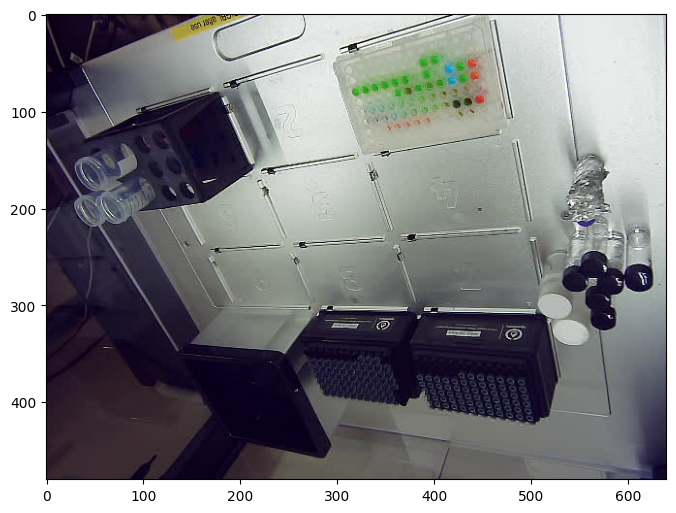

In [23]:
pic_folder = '.'  # Current folder (relative path)
# Read all the files from a specified directory
images_list=[]
# for (dirpath, dirnames, filenames) in os.walk(pic_folder):
#     for filename in filenames:
#         if filename!='.DS_Store':
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

for img in os.listdir(pic_folder):
    if img.endswith("captured_image.jpg"):
        image_path = os.path.join(pic_folder, img)
        image = Image.open(image_path, 'r')
        im = Image.fromarray(np.array(image, dtype=np.uint8), 'RGB')
        # Proceed with image processing

        # Create figure and axes
        fig,ax = plt.subplots(1,figsize=(8,8))
        # Display the image
        ax.imshow(im)
        plt.show()            
#
# test picture for adjusting the cropping box
# should try mutiple ones for the optimium cropping box options

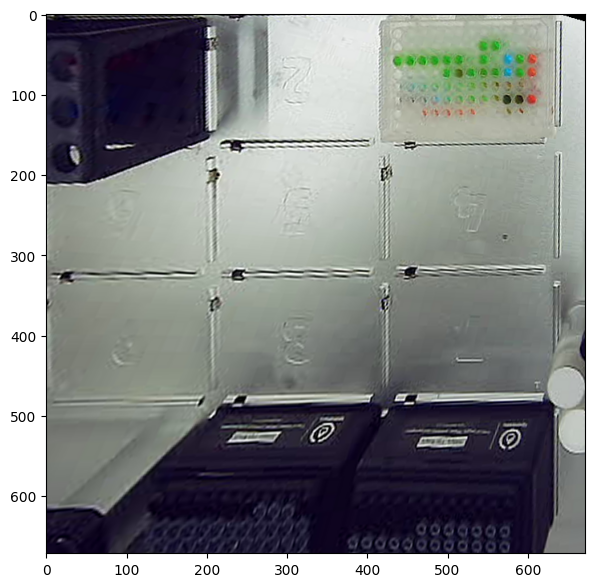

In [24]:
import numpy

def find_coeffs(pa, pb):
    matrix = []
    for p1, p2 in zip(pa, pb):
        matrix.append([p1[0], p1[1], 1, 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1]])
        matrix.append([0, 0, 0, p1[0], p1[1], 1, -p2[1]*p1[0], -p2[1]*p1[1]])

    A = numpy.matrix(matrix, dtype=float)  # <-- fixed here
    B = numpy.array(pb).reshape(8)

    res = numpy.dot(numpy.linalg.inv(A.T * A) * A.T, B)
    return numpy.array(res).reshape(8)

img = image
width, height = img.size
m = -0.1
n = 0.1
xshift = abs(m) * width
yshift = abs(n) * height
new_width = width + int(round(xshift))
new_height = height +int(round(yshift))
final_coeffs = [(94, 101), (460, 0), (520, 309), (196, 301)]  # Start with current
final_crop = (431, 14, 608, 150)
coeffs = find_coeffs(
        [(0, 0), (640, 0), (640, 480), (0, 480)],
        final_coeffs)

img_corr = img.transform((int(width*1.05), int(height*1.4)), Image.PERSPECTIVE, coeffs, Image.BICUBIC)

# Create figure and axes
fig,ax = plt.subplots(1,figsize=(7,7))
# Display the image
ax.imshow(img_corr)
plt.show()

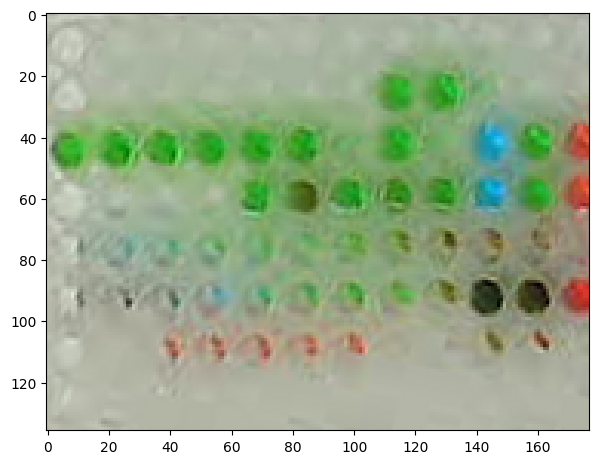

In [25]:
crop_box= final_crop 
image_cropped = img_corr.crop(box=crop_box) #box=(left, upper, right, lower)

# Create figure and axes
fig,ax = plt.subplots(1,figsize=(7,7))
# Display the image
ax.imshow(image_cropped)
plt.show()

In [26]:
import matplotlib.patches as patches

def get_image_array(image, crop_box):
    """Get a numpy array of an image so that one can access values[x][y]."""
    image = image.crop(box=crop_box) #box=(left, upper, right, lower)
    [width,height] = image.size
    pixel_values = list(image.getdata())
    if image.mode == 'RGB':
        channels = 3
    elif image.mode == 'L':
        channels = 1
    else:
        print("Unknown mode: %s" % image.mode)
        return None
    pixel_values = np.array(pixel_values).reshape((height, width, channels))
    return (width,height,pixel_values)

def image_slicing(image_array, col_num,row_num, offset_array):
    """slice the ROIs from an image of an array of samples/colorcard"""
    row_h = int(np.round(image_array.shape[0]/row_num))
    col_w = int(np.round(image_array.shape[1]/col_num))
    
    fig,ax = plt.subplots(1,figsize=(8,8))
    images = []
    imagecol = []
    for y in np.arange(row_num):
        imagerow = []
        for x in np.arange(col_num):
            # slicing indices for each color square
            y1 = row_h*y+offset_array[1][0]
            y2 = row_h*(y+1)-offset_array[1][1]
            x1 = col_w*x+offset_array[0][0]
            x2 = col_w*(x+1)-offset_array[0][1]
            image = image_array[y1:y2,x1:x2]
            imagerow.append(image)#append every images in a row into a row list
            images.append(image)#append every images into a list
            # Add the rectangular patch to the Axes
            # Create a Rectangle patch
            lw=1 # Line width
            ec='r' # edge color
            fc='none' # face color
            rect = patches.Rectangle((x1,y1),x2-x1,y2-y1,
                                      linewidth=lw,edgecolor=ec,facecolor=fc)
            ax.add_patch(rect)
    
        imagecol.append(np.concatenate(imagerow, axis=1))
    image_reconstr = np.array(np.concatenate(imagecol, axis=0), dtype=np.uint8)

    return [fig, ax, image_reconstr, images]


/var/folders/sv/vrr7b1q96js0n9_h6zt1sc200000gn/T/ipykernel_47273/3300536191.py:10: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  ax_ROI.imshow(Image.fromarray(np.array(image_array, dtype=np.uint8), 'RGB'))


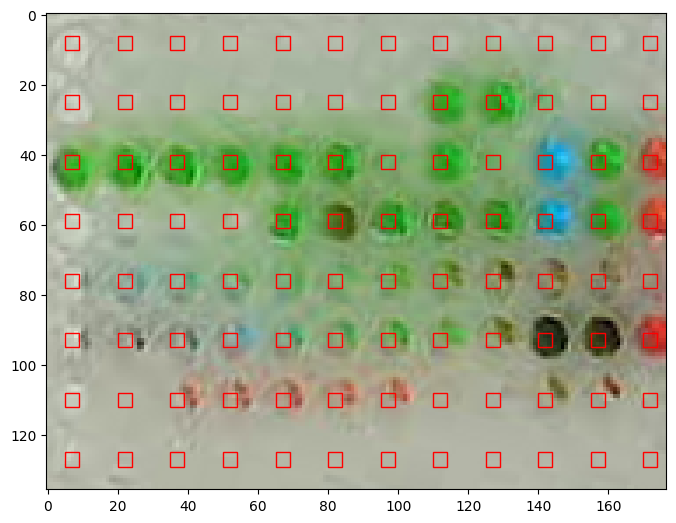

In [27]:
w, h, image_array = get_image_array(img_corr, crop_box)
              
# Row, Columns Settings and Offset pixels for each sample (TO BE CHANGED)
row_num=8
col_num=12
offset_array= [[5,6],[6,7]]#[[x_left,x_right],[y_upper,y_lower]]
########%%%%%%%%%%%%%%%%%%%%%%%%###############
[fig_ROI, ax_ROI, reconstr_ROI, image_ROI]= image_slicing(
        image_array, col_num, row_num, offset_array)
ax_ROI.imshow(Image.fromarray(np.array(image_array, dtype=np.uint8), 'RGB'))
fig_ROI.savefig(os.path.join(pic_folder, "reconstructed_with_boxes.jpg"))
plt.show()

from PIL import Image


In [8]:
#print(image_ROI)

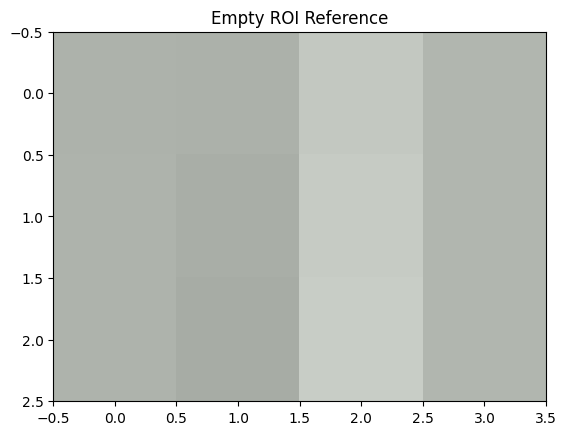

In [29]:
#Visulise empty_roi

# # Use this to load a previous rois.npy file, if rois have not been defined
img_dir = "./output/dispense_standalone"  # change to your actual folder
npy_path = os.path.join(img_dir, "rois.npy")
rois = np.load(npy_path, allow_pickle=True)  # allow_pickle=True if you saved a list

empty_roi = rois[1]  # A1, assuming it's always empty
empty_rgb = np.mean(empty_roi, axis=(1, 2))

plt.imshow(empty_roi)
plt.title("Empty ROI Reference")
plt.show()


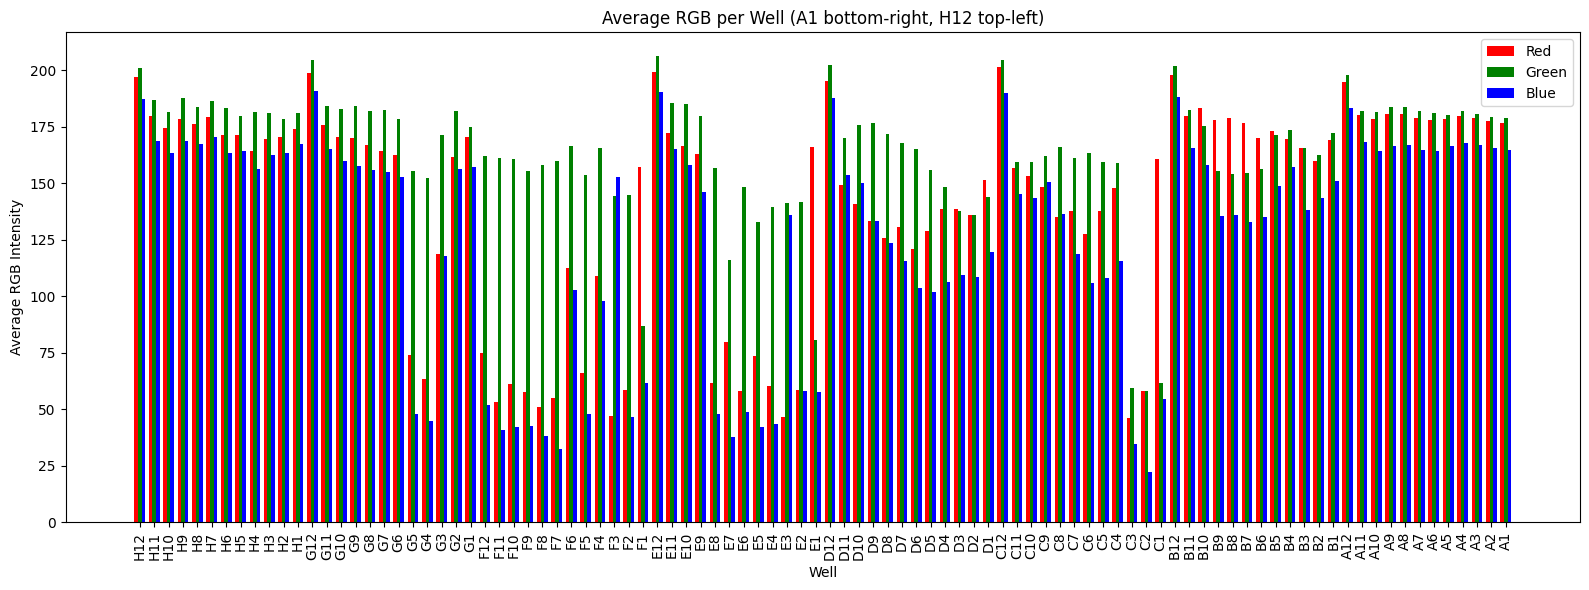

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# image_ROI is a list of numpy arrays from Part 12 (shape ~ [h,w,3])
# Map wells so that:
# - bottom-right is A1
# - bottom second-right is A2
# - second last row right is B1
# - top-left is H12
# image_slicing produced ROIs row-major from top-left to bottom-right:
#   row index y: 0..7 (top..bottom), col index x: 0..11 (left..right)
# We'll compute index -> (row, col) -> well name per the requested orientation.

rows = 8
cols = 12
row_letters = list("ABCDEFGH")  # A..H

# Compute average RGBs and build well names in requested orientation
avg_rgbs = []
well_names = []

for idx, roi in enumerate(image_ROI):
    y = idx // cols            # 0 top .. 7 bottom
    x = idx % cols             # 0 left .. 11 right

    # Requested orientation mapping
    row_letter = row_letters[(rows - 1) - y]     # bottom->top maps to A..H
    col_number = (cols - x)                      # right->left maps to 1..12

    well_name = f"{row_letter}{col_number}"
    well_names.append(well_name)

    rgb_avg = np.mean(np.array(roi), axis=(0, 1))  # [R,G,B]
    avg_rgbs.append(rgb_avg)

avg_rgbs = np.array(avg_rgbs)
r_vals = avg_rgbs[:, 0]
g_vals = avg_rgbs[:, 1]
b_vals = avg_rgbs[:, 2]

# Bar plot labeled with well names
x = np.arange(len(image_ROI))
width = 0.25

fig, ax = plt.subplots(figsize=(16, 6))
ax.bar(x - width, r_vals, width, color='red', label='Red')
ax.bar(x,         g_vals, width, color='green', label='Green')
ax.bar(x + width, b_vals, width, color='blue', label='Blue')

ax.set_xlabel("Well")
ax.set_ylabel("Average RGB Intensity")
ax.set_title("Average RGB per Well (A1 bottom-right, H12 top-left)")
ax.set_xticks(x)
ax.set_xticklabels(well_names, rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

# For convenience, also expose a dict mapping well -> RGB
well_to_rgb = {name: avg_rgbs[i].tolist() for i, name in enumerate(well_names)}


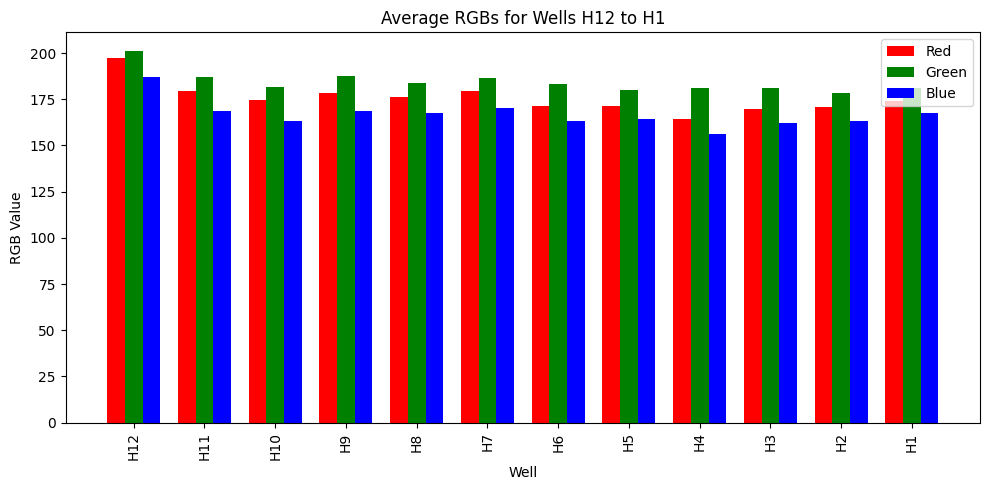

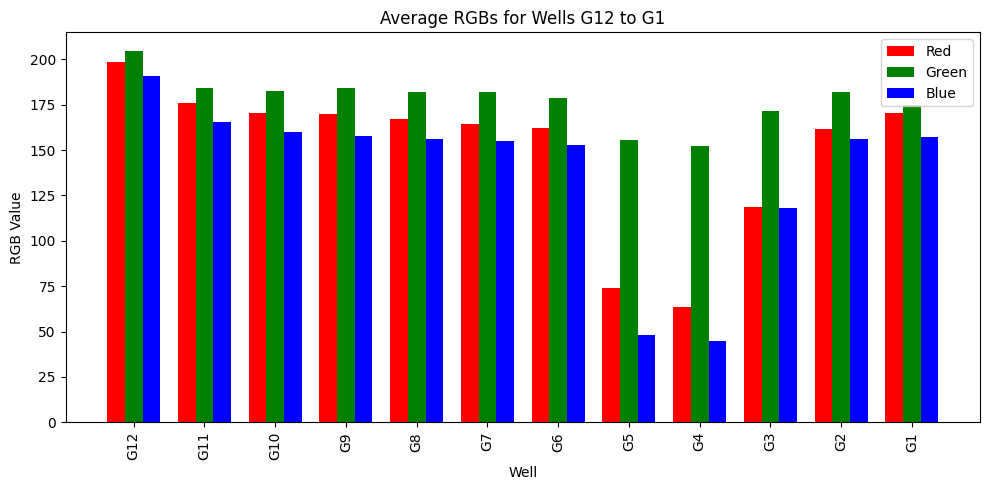

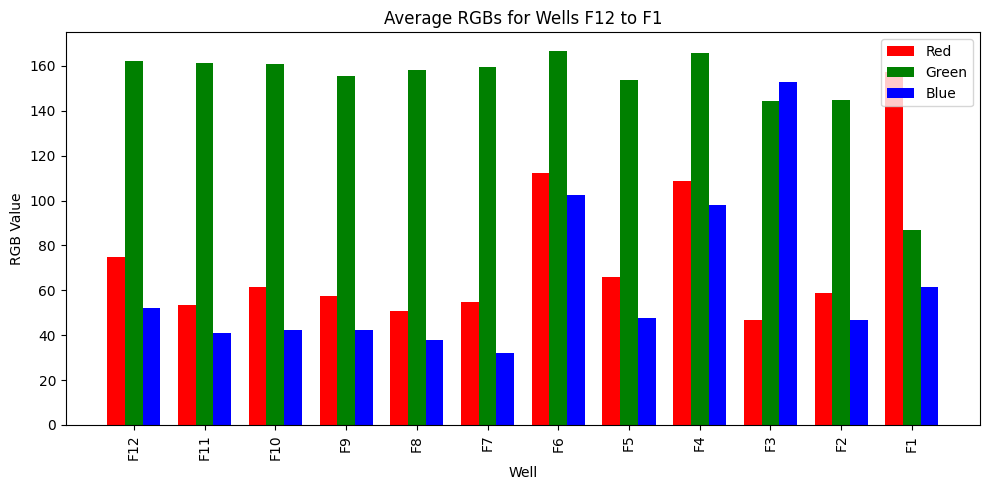

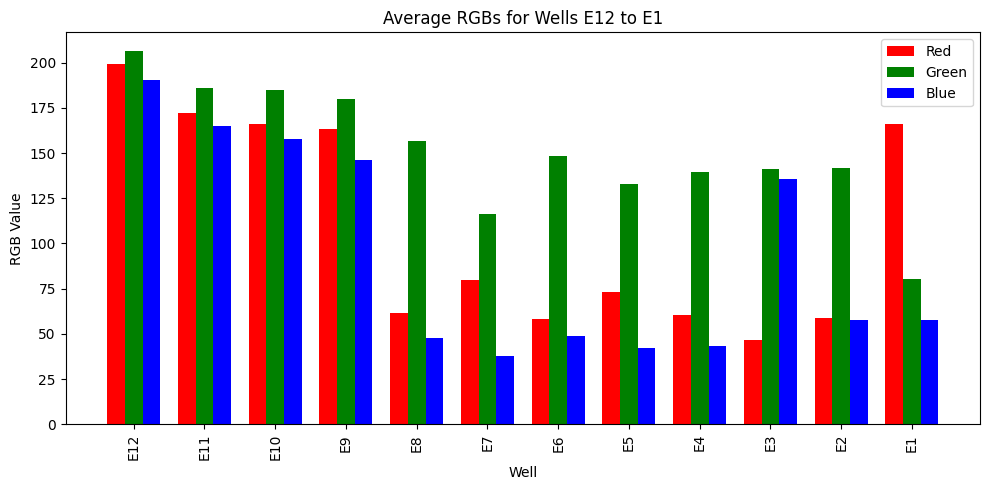

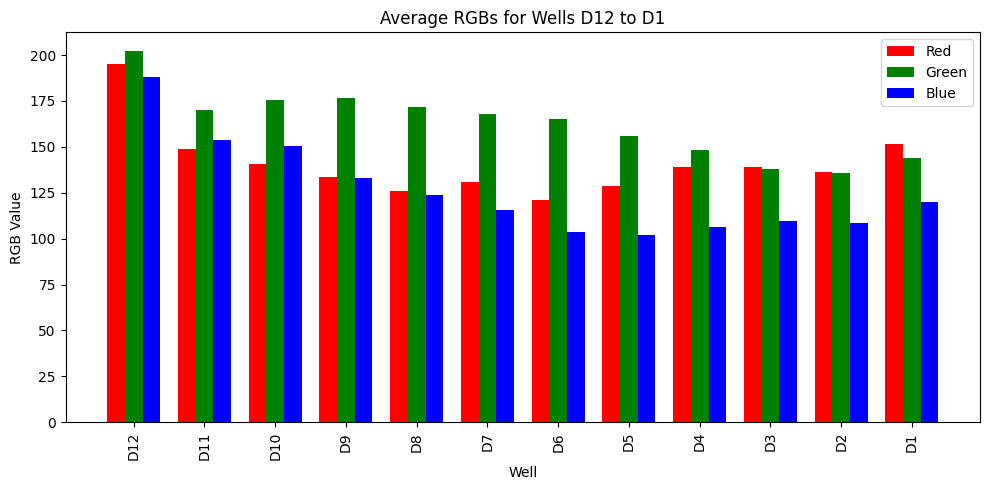

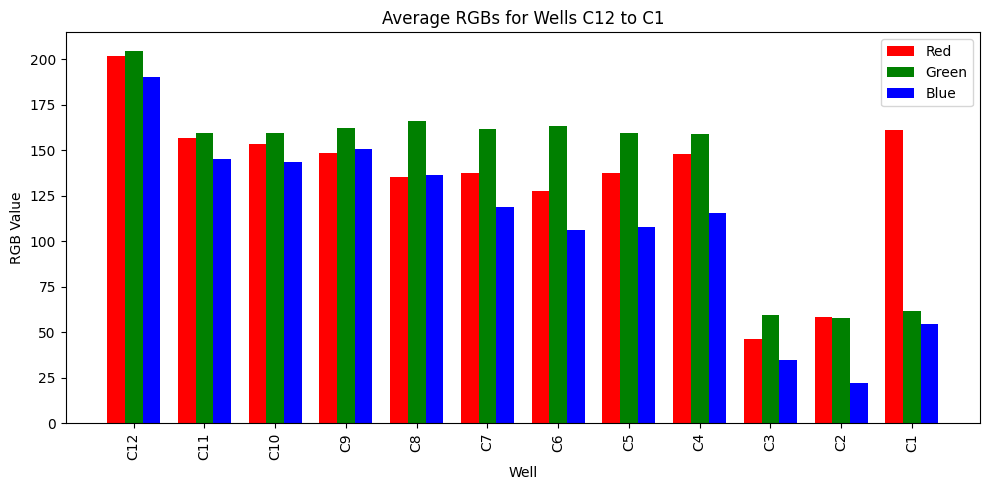

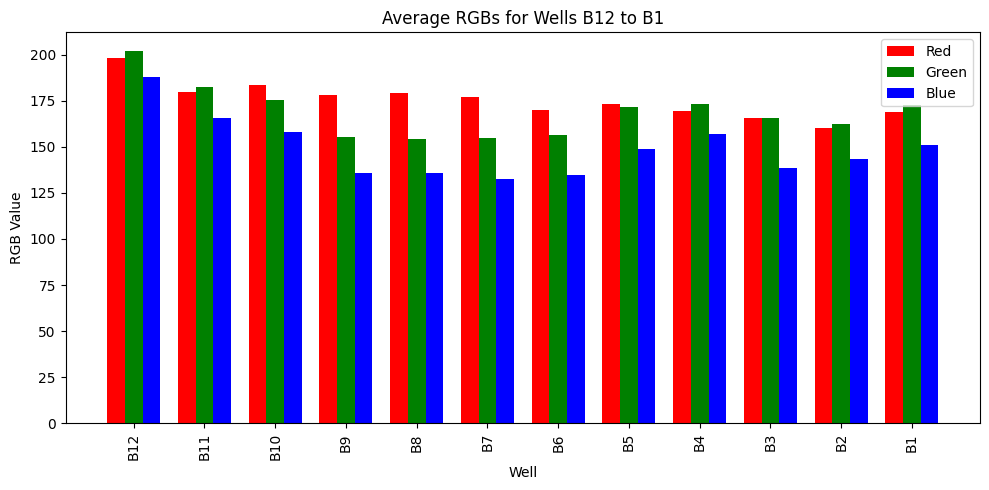

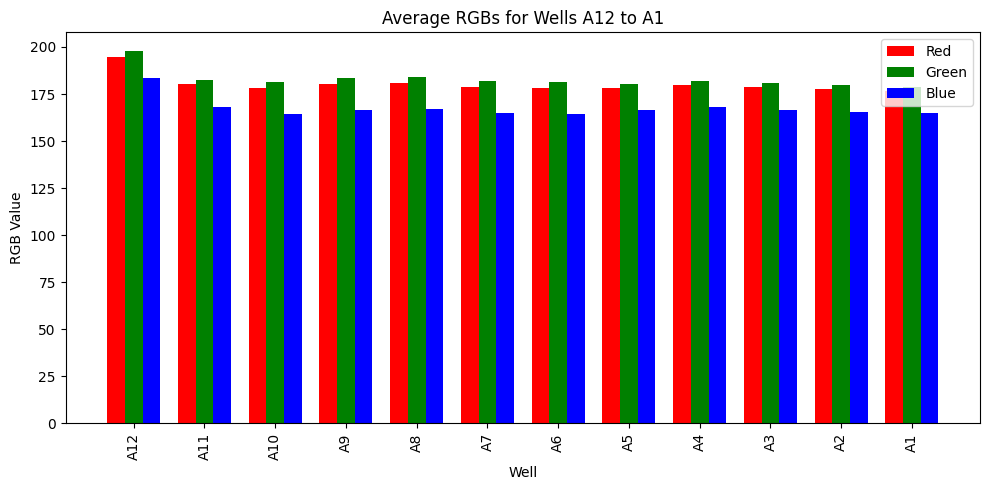

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Use avg_rgbs and well_names computed in the previous cell (Part 12b)
# avg_rgbs: numpy array of shape (96, 3)
# well_names: list of 96 strings like ["A1", ..., "H12"] according to requested orientation

# --- Plot in chunks for readability ---
def plot_rgb_chunks(avg_rgbs, well_names, chunk_size=10):
    num_chunks = int(np.ceil(len(avg_rgbs) / chunk_size))

    for c in range(num_chunks):
        start = c * chunk_size
        end = min((c + 1) * chunk_size, len(avg_rgbs))
        chunk = avg_rgbs[start:end]
        labels = well_names[start:end]

        r_vals = chunk[:, 0]
        g_vals = chunk[:, 1]
        b_vals = chunk[:, 2]
        x = np.arange(len(chunk))
        width = 0.25

        fig, ax = plt.subplots(figsize=(10, 5))
        ax.bar(x - width, r_vals, width, color='red', label='Red')
        ax.bar(x,         g_vals, width, color='green', label='Green')
        ax.bar(x + width, b_vals, width, color='blue', label='Blue')

        ax.set_title(f"Average RGBs for Wells {labels[0]} to {labels[-1]}")
        ax.set_xlabel("Well")
        ax.set_ylabel("RGB Value")
        ax.set_xticks(x)
        ax.set_xticklabels(labels, rotation=90)
        ax.legend()
        plt.tight_layout()
        plt.show()

# --- Call the function with labeled wells ---
plot_rgb_chunks(avg_rgbs, well_names, chunk_size=12)


In [32]:
# Extract RGB values of C1, C2, and C3
rgb_C1 = well_to_rgb.get("F1")
rgb_C2 = well_to_rgb.get("F2")
rgb_C3 = well_to_rgb.get("F3")

print("F1:", rgb_C1)
print("F2:", rgb_C2)
print("F3:", rgb_C3)

# Optionally, group into one array
selected_rgbs = np.array([rgb_C1, rgb_C2, rgb_C3])
print("Selected basis RGBs:", selected_rgbs)


F1: [157.4375, 87.0625, 61.625]
F2: [58.625, 144.6875, 46.5625]
F3: [46.875, 144.5625, 152.6875]
Selected basis RGBs: [[157.4375  87.0625  61.625 ]
 [ 58.625  144.6875  46.5625]
 [ 46.875  144.5625 152.6875]]


RGB values:
F1: [157.4375, 87.0625, 61.625]
F2: [58.625, 144.6875, 46.5625]
F3: [46.875, 144.5625, 152.6875]


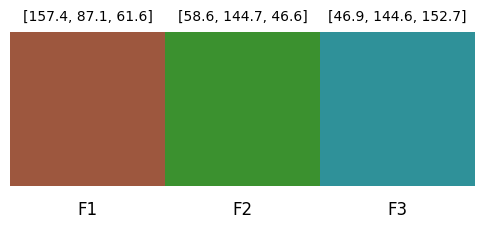

In [33]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Grab RGB values for C1, C2, C3
rgb_C1 = well_to_rgb.get("F1")
rgb_C2 = well_to_rgb.get("F2")
rgb_C3 = well_to_rgb.get("F3")

selected = {
    "F1": rgb_C1,
    "F2": rgb_C2,
    "F3": rgb_C3
}

print("RGB values:")
for well, rgb in selected.items():
    print(f"{well}: {rgb}")

# --- Plot swatches ---
fig, ax = plt.subplots(figsize=(6, 2))
for i, (well, rgb) in enumerate(selected.items()):
    # normalize to [0,1] for matplotlib
    color = np.array(rgb) / 255.0
    rect = Rectangle((i, 0), 1, 1, facecolor=color)
    ax.add_patch(rect)
    ax.text(i + 0.5, -0.1, well, ha="center", va="top", fontsize=12)
    ax.text(i + 0.5, 1.05, str([round(x,1) for x in rgb]), 
            ha="center", va="bottom", fontsize=10)

ax.set_xlim(0, len(selected))
ax.set_ylim(0, 1)
ax.axis("off")
plt.show()


# 3. Produce the target color in wellplate (40 points) 
Target RGB values (55,150,40).  
You should try to approach the target color as fast as possible, within minimum number of sample prepared. 

Hint: During the optimization process, the amount of liquid transferred differs between runs. So we need to automate the protocol generation process. 

protocol_generator.py and  bo_loop_example.py  might be a good reference (It is a working code generated from LLM, try beat it in you own implementation)

🎯 Target: [55.0, 150.0, 40.0]
[seed] pure A                 (a,b,c)=(1.000,0.000,0.000) mix≈[157.4  87.1  61.6] err≈122.16
[seed] pure B                 (a,b,c)=(0.000,1.000,0.000) mix≈[ 58.6 144.7  46.6] err≈9.19
[seed] pure C                 (a,b,c)=(0.000,0.000,1.000) mix≈[ 46.9 144.6 152.7] err≈113.11
[seed] centroid               (a,b,c)=(0.333,0.333,0.333) mix≈[ 87.6 125.4  87. ] err≈62.24
[seed] target-direction guess (a,b,c)=(0.224,0.612,0.163) mix≈[ 78.9 131.7  67.3] err≈40.60
[seed] replicate of guess     (a,b,c)=(0.224,0.612,0.163) mix≈[ 78.9 131.7  67.3] err≈40.60

---- BO iteration 1 ----


/opt/miniconda3/envs/jupyter/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0, 1.0] before, using random point [0.19069818626232876, 0.47629834297678164]
  warnings.warn(
/opt/miniconda3/envs/jupyter/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0, 1.0] before, using random point [0.30076649508956393, 0.5740458751860523]
  warnings.warn(
/opt/miniconda3/envs/jupyter/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0, 1.0] before, using random point [0.8631167131926615, 0.3777817976937745]
  warnings.warn(
/opt/miniconda3/envs/jupyter/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0, 1.0] before, using random point [0.5730310975393285, 0.9143319180544577]
  warnings.warn(
/opt/miniconda3/envs/jupy

✅ Created protocol file: Q3_protocol_iter1.py
Protocol finished: succeeded
📸 Saved: captured_image.jpg


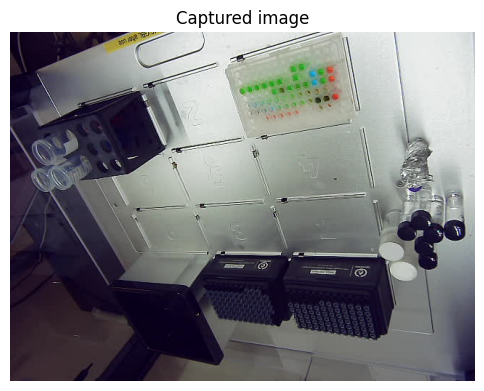

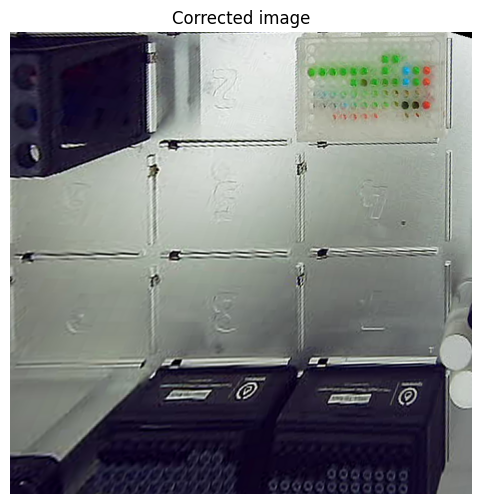

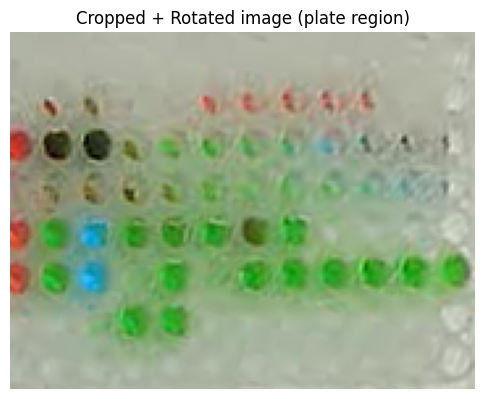

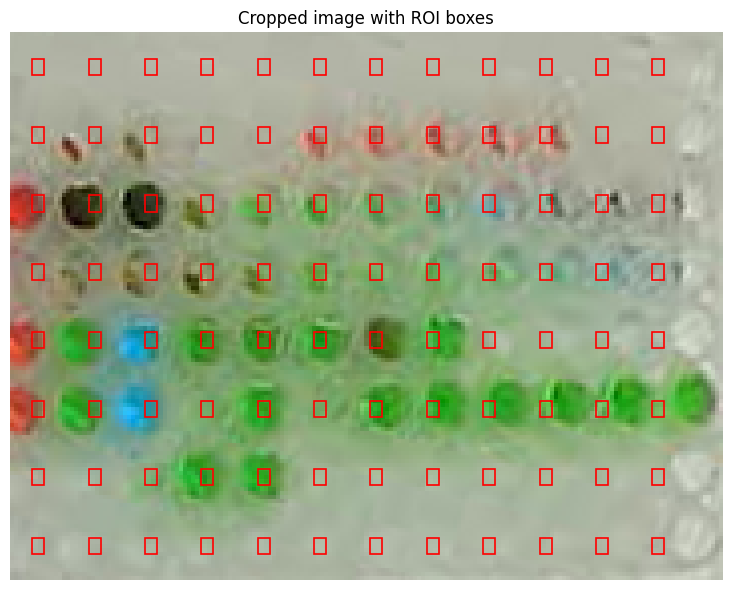

📌 Using ROI for G4: linear index 75


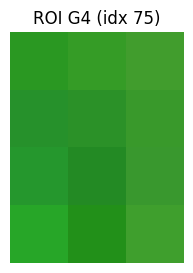

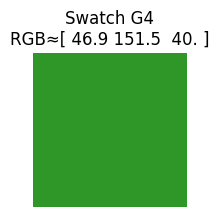

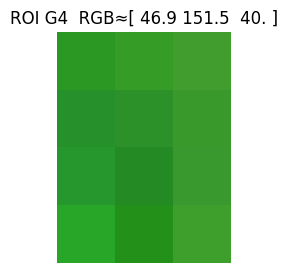

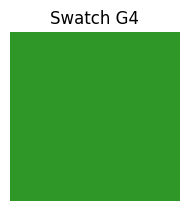

[bo] iter 1 -> G4: (a,b,c)=(0.000,1.000,0.000) RGB=[ 46.9 151.5  40. ] err=8.22
Best so far: err=8.22, mix≈[ 46.9 151.5  40. ], (a,b,c)=(0.000,1.000,0.000) at G4

---- BO iteration 2 ----


/opt/miniconda3/envs/jupyter/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0, 1.0] before, using random point [0.9153343987552461, 0.6762740767231517]
  warnings.warn(
/opt/miniconda3/envs/jupyter/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0, 1.0] before, using random point [0.95864830653257, 0.44270410598598997]
  warnings.warn(
/opt/miniconda3/envs/jupyter/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0, 1.0] before, using random point [0.927319792201596, 0.6087349903517719]
  warnings.warn(
/opt/miniconda3/envs/jupyter/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0, 1.0] before, using random point [0.5616257029687666, 0.7432029517753131]
  warnings.warn(
/opt/miniconda3/envs/jupyter/l

✅ Created protocol file: Q3_protocol_iter2.py
Protocol finished: succeeded
📸 Saved: captured_image.jpg


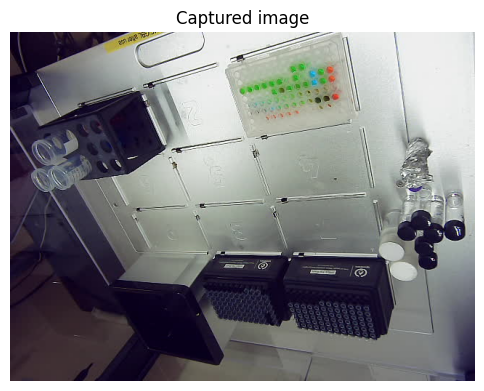

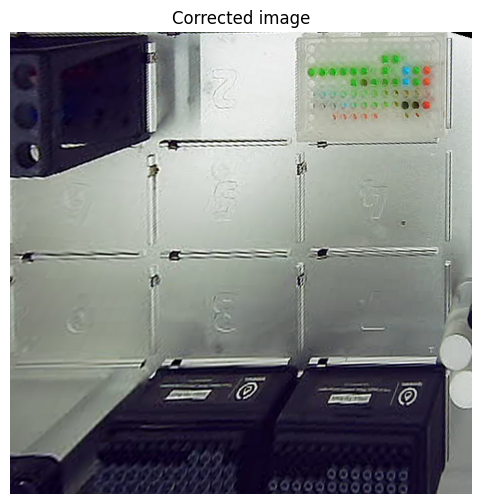

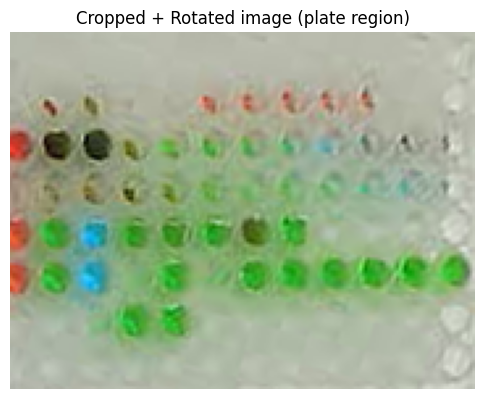

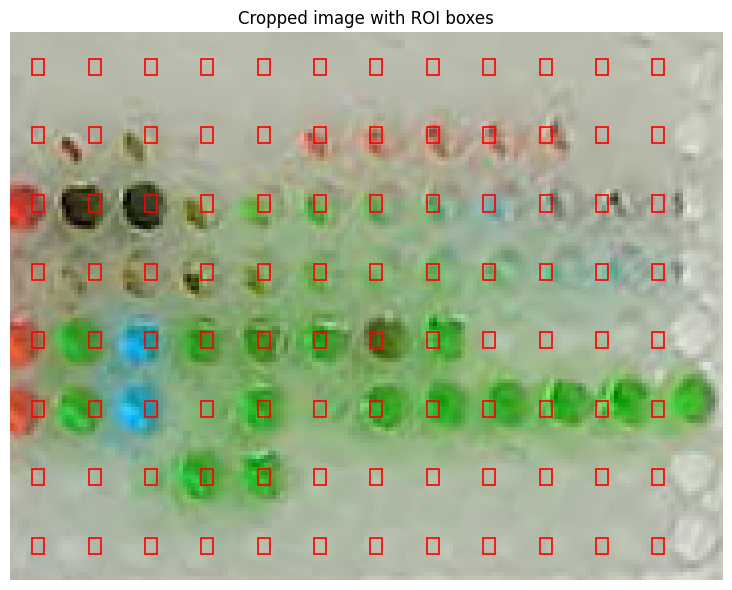

📌 Using ROI for G5: linear index 76


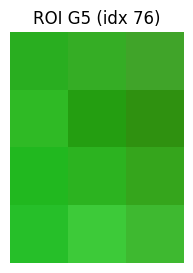

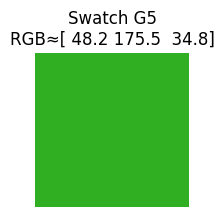

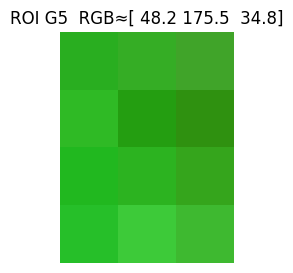

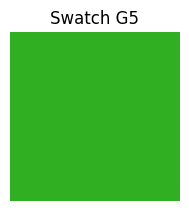

[bo] iter 2 -> G5: (a,b,c)=(0.000,1.000,0.000) RGB=[ 48.2 175.5  34.8] err=26.90

---- BO iteration 3 ----


/opt/miniconda3/envs/jupyter/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0, 1.0] before, using random point [0.18444790945850068, 0.44017024343832145]
  warnings.warn(
/opt/miniconda3/envs/jupyter/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0, 1.0] before, using random point [0.49306692476958325, 0.38059272670259836]
  warnings.warn(
/opt/miniconda3/envs/jupyter/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0, 1.0] before, using random point [0.11704752319971026, 0.746533987593378]
  warnings.warn(
/opt/miniconda3/envs/jupyter/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0, 1.0] before, using random point [0.8653246479649626, 0.11088946072714304]
  warnings.warn(
/opt/miniconda3/envs/ju

✅ Created protocol file: Q3_protocol_iter3.py
Protocol finished: succeeded
📸 Saved: captured_image.jpg


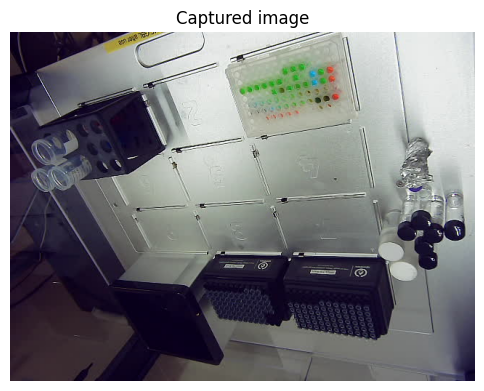

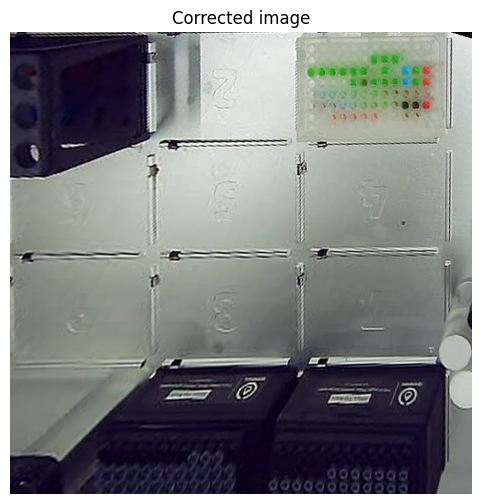

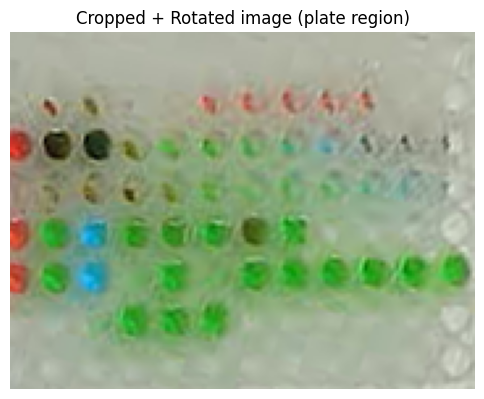

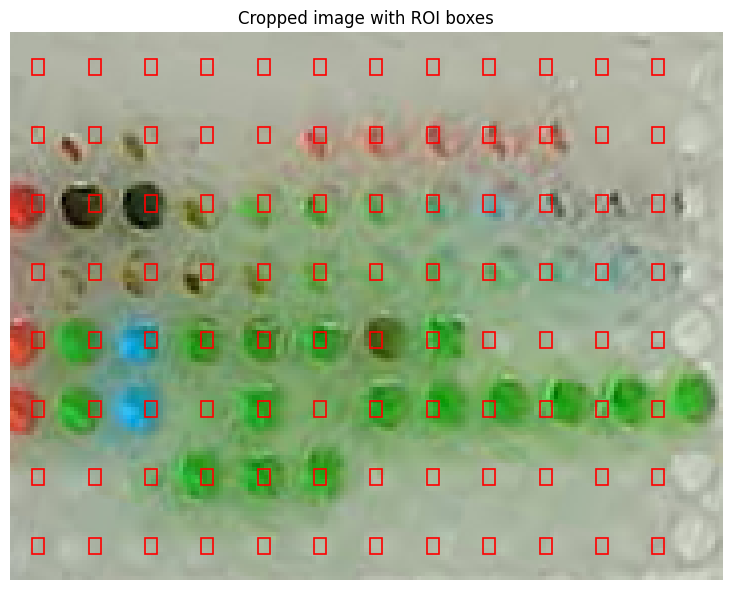

📌 Using ROI for G6: linear index 77


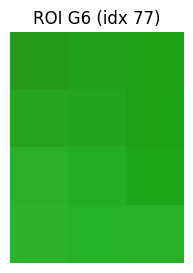

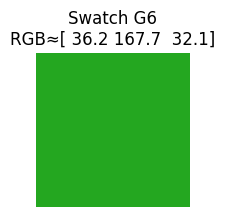

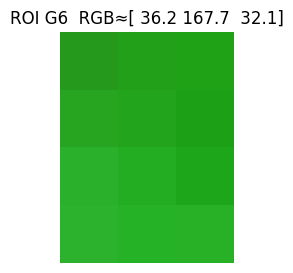

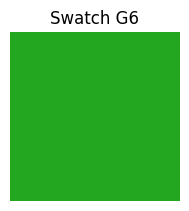

[bo] iter 3 -> G6: (a,b,c)=(0.000,1.000,0.000) RGB=[ 36.2 167.7  32.1] err=27.01

---- BO iteration 4 ----


/opt/miniconda3/envs/jupyter/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0, 1.0] before, using random point [0.44970097186480196, 0.5147721698278904]
  warnings.warn(
/opt/miniconda3/envs/jupyter/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0, 1.0] before, using random point [0.6633578417817638, 0.14730641279642612]
  warnings.warn(
/opt/miniconda3/envs/jupyter/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0, 1.0] before, using random point [0.10343634550728889, 0.6350521283650463]
  warnings.warn(


✅ Created protocol file: Q3_protocol_iter4.py
Protocol finished: succeeded
📸 Saved: captured_image.jpg


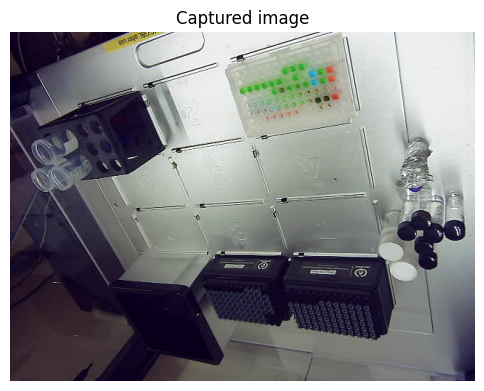

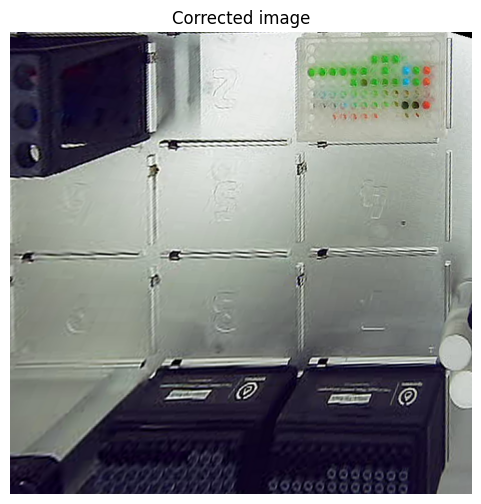

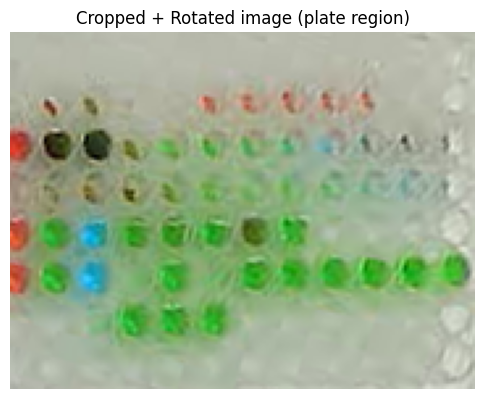

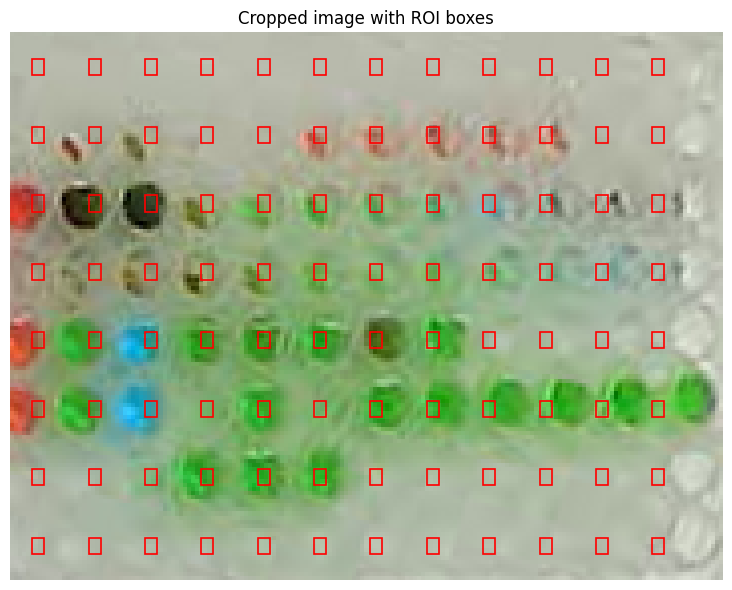

📌 Using ROI for G7: linear index 78


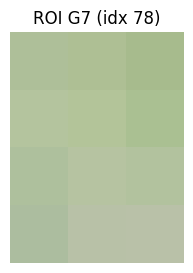

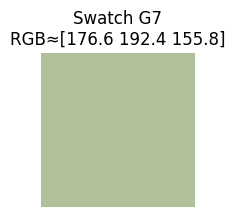

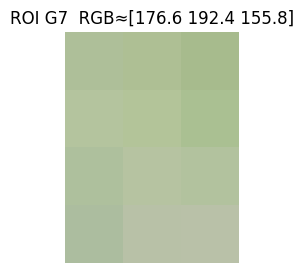

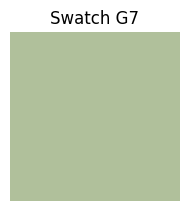

[bo] iter 4 -> G7: (a,b,c)=(0.000,1.000,0.000) RGB=[176.6 192.4 155.8] err=173.15

---- BO iteration 5 ----


/opt/miniconda3/envs/jupyter/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0, 1.0] before, using random point [0.779963157652055, 0.7268281405979401]
  warnings.warn(
/opt/miniconda3/envs/jupyter/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0, 1.0] before, using random point [0.12302322262674262, 0.5655665640838515]
  warnings.warn(
/opt/miniconda3/envs/jupyter/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0, 1.0] before, using random point [0.8882017775989934, 0.7487438926818083]
  warnings.warn(
/opt/miniconda3/envs/jupyter/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0, 1.0] before, using random point [0.2974010418706307, 0.7326747503770529]
  warnings.warn(
/opt/miniconda3/envs/jupyter

✅ Created protocol file: Q3_protocol_iter5.py


KeyboardInterrupt: 

In [37]:
# ===== giant_bo_robot_loop.py (1 candidate per iteration, auto-make .py each run) =====
import os, time, numpy as np, requests
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image

# ---------------- Config ----------------
RNG = np.random.RandomState(42)
ERROR_THRESHOLD = 6
MAX_ITERS = 10
BATCH_SIZE = 1              # <-- ONE candidate per BO iteration
TOTAL_VOL_UL = 300          # <-- your current total/well
VERBOSE = True

# Expected globals set outside:
# BASE_URL = "http://<ot2-ip>:31950"
# HEADERS  = {"opentrons-version": "2", "Authorization": "Bearer <token>"}

# ---------------- Optional skopt ----------------
try:
    from skopt import gp_minimize
    from skopt.space import Real
    SKOPT_OK = True
except Exception:
    SKOPT_OK = False

# ---------------- Helpers: simplex, mixing, errors ----------------
def project_to_simplex(a, b):
    a = float(np.clip(a, 0.0, 1.0))
    b = float(np.clip(b, 0.0, 1.0))
    if a + b > 1.0:
        s = a + b
        a, b = a / s, b / s
    c = 1.0 - a - b
    return a, b, c

def to_logits(fracs, eps=1e-12):
    f = np.clip(np.array(fracs, float), eps, 1.0); f = f / f.sum()
    return np.log(f)

def softmax_simplex(z):
    z = np.array(z, float); z = z - z.max()
    e = np.exp(z); p = e / e.sum()
    return float(p[0]), float(p[1]), float(p[2])

def mix_rgb(fracs, basis_rgbs):
    a,b,c = fracs
    return a*basis_rgbs[0] + b*basis_rgbs[1] + c*basis_rgbs[2]

def rgb_err(rgb, target):
    return float(np.linalg.norm(np.array(rgb, float) - np.array(target, float)))

def rgb_to_volumes(a, b, c, total_ul=TOTAL_VOL_UL):
    va = int(round(total_ul * a))
    vb = int(round(total_ul * b))
    vc = total_ul - va - vb
    return va, vb, vc

# ---------------- Seeds ----------------
def seed_candidates(target_rgb):
    seeds = [
        (1.0, 0.0, 0.0, "pure A"),
        (0.0, 1.0, 0.0, "pure B"),
        (0.0, 0.0, 1.0, "pure C"),
        (1/3, 1/3, 1/3, "centroid"),
    ]
    w = np.array(target_rgb, float)
    w = w / w.sum() if w.sum() > 0 else np.array([1.0, 0.0, 0.0])
    seeds.append((float(w[0]), float(w[1]), float(w[2]), "target-direction guess"))
    seeds.append((float(w[0]), float(w[1]), float(w[2]), "replicate of guess"))
    return seeds

# ---------------- Acquisition (BO proposer) ----------------
def propose_batch(basis_rgbs, target_rgb, n, evaluated=None):
    """
    Return n new (a,b,c). With n=1, we still reuse this to keep code simple.
    """
    if not SKOPT_OK:
        return [tuple(map(float, x)) for x in RNG.dirichlet([1,1,1], size=n)]

    space = [Real(0.0, 1.0, name="a"), Real(0.0, 1.0, name="b")]

    def obj(x):
        a,b = x
        a,b,c = project_to_simplex(a,b)
        mixed = mix_rgb((a,b,c), basis_rgbs)
        return rgb_err(mixed, target_rgb)

    res = gp_minimize(obj, space, n_calls=25,
                      random_state=RNG.randint(0,1_000_000),
                      acq_func="gp_hedge", xi=0.01, kappa=0.75)

    a_best, b_best = res.x
    a_best, b_best, c_best = project_to_simplex(a_best, b_best)
    out = []
    z_best = to_logits((a_best,b_best,c_best))
    z = z_best + RNG.normal(0, 0.15, size=3)
    out.append(softmax_simplex(z))
    return out[:n]

# ---------------- Auto-create a protocol .py file (per run) ----------------
def create_protocol_file(filename, color_recipes):
    """
    Generate a new OT-2 protocol .py file with given color_recipes embedded.
    Reservoir mapping: A->B3 (red), B->A4 (green), C->A3 (blue).
    """
    content = f"""\
from opentrons import protocol_api

metadata = {{
    'protocolName': 'Auto-Generated Protocol',
    'author': 'giant_bo_robot_loop',
    'apiLevel': '2.13'
}}

# Auto-generated recipes (µL per well)
color_recipes = {repr(color_recipes)}

def run(protocol: protocol_api.ProtocolContext):
    plate = protocol.load_labware('corning_96_wellplate_360ul_flat', '1')
    tiprack = protocol.load_labware('opentrons_96_tiprack_300ul', '11')
    reservoir = protocol.load_labware('opentrons_10_tuberack_falcon_4x50ml_6x15ml_conical', '3')

    pipette = protocol.load_instrument('p300_single_gen2', 'left', tip_racks=[tiprack])

    src_A = reservoir['B3']  # Red (A)
    src_B = reservoir['A4']  # Green (B)
    src_C = reservoir['A3']  # Blue (C)

    wells_in_order = list(color_recipes.keys())

    # A channel
    pipette.pick_up_tip()
    for well in wells_in_order:
        vol = int(color_recipes[well].get('B3', 0))
        if vol > 0:
            pipette.aspirate(vol, src_A)
            pipette.dispense(vol, plate[well])
    pipette.drop_tip()

    # B channel
    pipette.pick_up_tip()
    for well in wells_in_order:
        vol = int(color_recipes[well].get('A4', 0))
        if vol > 0:
            pipette.aspirate(vol, src_B)
            pipette.dispense(vol, plate[well])
    pipette.drop_tip()

    # C channel
    pipette.pick_up_tip()
    for well in wells_in_order:
        vol = int(color_recipes[well].get('A3', 0))
        if vol > 0:
            pipette.aspirate(vol, src_C)
            pipette.dispense(vol, plate[well])
    pipette.drop_tip()

    protocol.comment(f"✅ Mixed {{len(wells_in_order)}} well(s).")
"""
    with open(filename, "w") as f:
        f.write(content)
    print(f"✅ Created protocol file: {filename}")

# ---------------- Protocol upload + run (per-candidate) ----------------
def upload_protocol_path(BASE_URL, HEADERS, protocol_path):
    with open(protocol_path, 'rb') as fh:
        files = [('files', (os.path.basename(protocol_path), fh))]
        r = requests.post(f"{BASE_URL}/protocols", headers=HEADERS, files=files)
    if not r.ok:
        raise RuntimeError(f"Protocol upload failed: {r.status_code} {r.text}")
    return r.json()["data"]["id"]

def create_and_start_run(BASE_URL, HEADERS, protocol_id):
    r = requests.post(f"{BASE_URL}/runs", headers=HEADERS,
                      json={"data": {"protocolId": protocol_id}})
    if not r.ok:
        raise RuntimeError(f"Create run failed: {r.status_code} {r.text}")
    run_id = r.json()["data"]["id"]
    s = requests.post(f"{BASE_URL}/runs/{run_id}/actions", headers=HEADERS,
                      json={"data": {"actionType": "play"}})
    if not s.ok:
        raise RuntimeError(f"Start run failed: {s.status_code} {s.text}")
    return run_id

def wait_until_finished(BASE_URL, HEADERS, run_id, poll_sec=5):
    while True:
        status_resp = requests.get(f"{BASE_URL}/runs/{run_id}", headers=HEADERS)
        status = status_resp.json()["data"]["status"]
        if status in ("succeeded","failed","stopped"):
            print(f"Protocol finished: {status}")
            break
        time.sleep(poll_sec)

def run_protocol_for_well(well_name, a, b, c, BASE_URL, HEADERS, iter_idx=None):
    """
    Build a one-well color_recipes dict, write a NEW protocol .py file,
    upload & run it, then wait until completion.
    """
    va, vb, vc = rgb_to_volumes(a, b, c, TOTAL_VOL_UL)
    color_recipes = {well_name: {"B3": int(va), "A4": int(vb), "A3": int(vc)}}

    # unique filename per iteration (or timestamp fallback)
    proto_name = f"Q3_protocol_iter{iter_idx}.py" if iter_idx is not None else f"Q3_protocol_{int(time.time())}.py"
    create_protocol_file(proto_name, color_recipes)

    protocol_id = upload_protocol_path(BASE_URL, HEADERS, proto_name)
    run_id = create_and_start_run(BASE_URL, HEADERS, protocol_id)
    wait_until_finished(BASE_URL, HEADERS, run_id)
    return run_id

# ---------------- Image capture + perspective correction + ROI slicing ----------------
def find_coeffs(pa, pb):
    import numpy as _np
    matrix = []
    for p1, p2 in zip(pa, pb):
        matrix.append([p1[0], p1[1], 1, 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1]])
        matrix.append([0, 0, 0, p1[0], p1[1], 1, -p2[1]*p1[0], -p2[1]*p1[1]])
    A = _np.matrix(matrix, dtype=float)
    B = _np.array(pb).reshape(8)
    res = _np.dot(_np.linalg.inv(A.T * A) * A.T, B)
    return _np.array(res).reshape(8)

FINAL_COEFFS = [(94, 101), (460, 0), (520, 309), (196, 301)]
FINAL_CROP   = (431, 14, 608, 150)
OFFSET       = ((5,6), (6,7))
ROWS, COLS   = 8, 12

"""def capture_image(BASE_URL, HEADERS, filename="captured_image.jpg"):
    r = requests.post(f"{BASE_URL}/camera/picture", headers=HEADERS)
    if not r.ok:
        print("❌ Failed to capture image.")
        return None
    with open(filename, "wb") as f:
        f.write(r.content)
    print(f"📸 Saved: {filename}")
    return filename"""
def capture_image(BASE_URL, HEADERS, filename="captured_image.jpg"):
    r = requests.post(f"{BASE_URL}/camera/picture", headers=HEADERS)
    if not r.ok:
        print("❌ Failed to capture image.")
        return None
    with open(filename, "wb") as f:
        f.write(r.content)
    print(f"📸 Saved: {filename}")

    # show captured
    try:
        img = Image.open(filename).convert("RGB")
        plt.figure(figsize=(6,6))
        plt.imshow(img)
        plt.title("Captured image")
        plt.axis("off")
        plt.show()
    except Exception as e:
        print(f"(Could not display captured image: {e})")

    return filename


"""def correct_and_crop(image_path, out_corr="corrected.jpg", out_crop="cropped.jpg"):
    img = Image.open(image_path).convert("RGB")
    w, h = img.size
    coeffs = find_coeffs([(0,0),(640,0),(640,480),(0,480)], FINAL_COEFFS)
    img_corr = img.transform((int(w*1.05), int(h*1.4)),
                             Image.PERSPECTIVE, coeffs, Image.BICUBIC)
    img_corr.save(out_corr)
    cropped = img_corr.crop(FINAL_CROP)
    cropped.save(out_crop)
    return cropped"""
def correct_and_crop(image_path, out_corr="corrected.jpg", out_crop="cropped.jpg"):
    img = Image.open(image_path).convert("RGB")
    w, h = img.size
    coeffs = find_coeffs([(0,0),(640,0),(640,480),(0,480)], FINAL_COEFFS)
    img_corr = img.transform((int(w*1.05), int(h*1.4)),
                             Image.PERSPECTIVE, coeffs, Image.BICUBIC)
    img_corr.save(out_corr)

    # show corrected
    try:
        plt.figure(figsize=(6,6))
        plt.imshow(img_corr)
        plt.title("Corrected image")
        plt.axis("off")
        plt.show()
    except Exception as e:
        print(f"(Could not display corrected image: {e})")

    cropped = img_corr.crop(FINAL_CROP)

    # rotate 180°
    cropped = cropped.rotate(180)

    cropped.save(out_crop)

    # show cropped (rotated)
    try:
        plt.figure(figsize=(6,6))
        plt.imshow(cropped)
        plt.title("Cropped + Rotated image (plate region)")
        plt.axis("off")
        plt.show()
    except Exception as e:
        print(f"(Could not display cropped image: {e})")

    return cropped

def draw_boxes_and_slice(cropped_img, rows=ROWS, cols=COLS, offset=OFFSET):
    """
    Show cropped image with red ROI boxes overlaid and return the sliced ROIs.
    """
    pix = np.array(cropped_img)
    h, w, _ = pix.shape
    dh, dw = h // rows, w // cols

    fig, ax = plt.subplots(figsize=(8,6))
    ax.imshow(pix.astype(np.uint8))
    ax.set_title("Cropped image with ROI boxes")
    ax.axis("off")

    rois = []
    for r in range(rows):
        for c in range(cols):
            y1 = r*dh + offset[1][0]
            y2 = (r+1)*dh - offset[1][1]
            x1 = c*dw + offset[0][0]
            x2 = (c+1)*dw - offset[0][1]

            # draw box
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                     linewidth=1.2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

            rois.append(pix[y1:y2, x1:x2])

    plt.tight_layout()
    plt.show()
    return rois

def slice_rois(pix, rows=ROWS, cols=COLS, offset=OFFSET):
    h, w, _ = pix.shape
    dh, dw = h // rows, w // cols
    rois = []
    for r in range(rows):
        for c in range(cols):
            y1 = r*dh + offset[1][0]
            y2 = (r+1)*dh - offset[1][1]
            x1 = c*dw + offset[0][0]
            x2 = (c+1)*dw - offset[0][1]
            rois.append(pix[y1:y2, x1:x2])
    return rois

# ---------------- Well <-> ROI index mapping ----------------
def well_to_index_with_rc(well, rows=ROWS, cols=COLS):
    """
    Map well such that A1 is bottom-right and H12 is top-left.
    Returns (linear_index, row_idx, col_idx), all 0-based.
    """
    row_letter = well[0].upper()       # 'A'..'H'
    col_num = int(well[1:])            # 1..12

    # Flip row: A->bottom, H->top
    row_idx = (rows - 1) - (ord(row_letter) - ord('A'))

    # Flip column: 1->right, 12->left
    col_idx = (cols - col_num)

    linear = row_idx * cols + col_idx
    return linear, row_idx, col_idx



def c_row_well_for_iteration(iter_idx):
    """
    With one candidate per iteration, wells are C4, C5, C6, ...
    iter_idx: 1-based iteration number
    """
    col = 3 + iter_idx  # iter1->4, iter2->5, ...
    return f"G{col}"

# ---------------- Main BO loop with robot feedback ----------------
def run_bo_with_robot(selected_rgbs, target_rgb,
                      BASE_URL, HEADERS,
                      max_iters=MAX_ITERS, batch_size=BATCH_SIZE,
                      error_threshold=ERROR_THRESHOLD, verbose=VERBOSE):

    basis = [np.array(selected_rgbs[0], float),
             np.array(selected_rgbs[1], float),
             np.array(selected_rgbs[2], float)]

    # Seeds (bookkeeping only)
    history = []
    for (a,b,c,tag) in seed_candidates(target_rgb):
        mix_est = mix_rgb((a,b,c), basis)
        err_est = rgb_err(mix_est, target_rgb)
        history.append(dict(iter=0, a=a,b=b,c=c, mixed_rgb=mix_est, error=err_est, tag=tag))
        if verbose:
            print(f"[seed] {tag:22s} (a,b,c)=({a:.3f},{b:.3f},{c:.3f}) "
                  f"mix≈{mix_est.round(1)} err≈{err_est:.2f}")

    best = min(history, key=lambda d: d["error"])

    # BO (one candidate per iteration)
    for it in range(1, max_iters+1):
        if best["error"] <= error_threshold:
            if verbose:
                print(f"\n✅ Stop at iter {it-1}: reached threshold ({best['error']:.2f} ≤ {error_threshold})")
            break

        if verbose: print(f"\n---- BO iteration {it} ----")

        # Propose exactly 1 candidate
        (a,b,c) = propose_batch(basis, target_rgb, n=1)[0]
        well = c_row_well_for_iteration(it)

        # Mix this candidate on the robot (auto-generate protocol file each time)
        run_protocol_for_well(well, a, b, c, BASE_URL, HEADERS, iter_idx=it)

        # Capture & measure
        img_path = capture_image(BASE_URL, HEADERS, filename="captured_image.jpg")
        if img_path is None:
            measured_rgb, err = None, None
        else:
            cropped = correct_and_crop(img_path, out_corr="corrected.jpg", out_crop="cropped.jpg")
            # OLD:
# rois = slice_rois(np.array(cropped))

# NEW: draw boxes and slice
        rois = draw_boxes_and_slice(cropped)

        roi_idx, r_idx, c_idx = well_to_index(well), None, None  # keep old call if you want
# or, if you added the helper that returns row/col too:
# roi_idx, r_idx, c_idx = well_to_index_with_rc(well)

        print(f"📌 Using ROI for {well}: linear index {roi_idx}")
        if 0 <= roi_idx < len(rois):
            roi_img = rois[roi_idx].astype(np.uint8)
            measured_rgb = np.mean(roi_img, axis=(0,1))
            err = rgb_err(measured_rgb, target_rgb)

            # show ROI
            try:
                plt.figure(figsize=(3,3))
                plt.imshow(roi_img)
                plt.title(f"ROI {well} (idx {roi_idx})")
                plt.axis("off")
                plt.show()
            except Exception as e:
                print(f"(Could not display ROI image: {e})")

    # show swatch
            try:
                swatch = np.ones((60, 60, 3), dtype=np.uint8)
                swatch[:] = np.clip(measured_rgb, 0, 255).astype(np.uint8)
                plt.figure(figsize=(2,2))
                plt.imshow(swatch)
                plt.title(f"Swatch {well}\nRGB≈{np.round(measured_rgb,1)}")
                plt.axis("off")
                plt.show()
            except Exception as e:
                print(f"(Could not display swatch: {e})")
        else:
            measured_rgb, err = None, None

                        # --- Visualize the ROI and a color swatch ---
        if measured_rgb is not None:
            roi_img = rois[roi_idx]  # numpy array (h,w,3), uint8-ish
            rgb_255 = np.clip(measured_rgb, 0, 255).astype(np.uint8)

            # Show the ROI that was measured
            plt.figure(figsize=(3,3))
            plt.imshow(roi_img)
            plt.axis('off')
            plt.title(f"ROI {well}  RGB≈{np.round(measured_rgb,1)}")
            plt.show()

            # Show a solid color swatch for the measured RGB
            swatch = np.ones((80, 80, 3), dtype=np.uint8) * rgb_255.reshape(1,1,3)
            plt.figure(figsize=(2.2,2.2))
            plt.imshow(swatch)
            plt.axis('off')
            plt.title(f"Swatch {well}")
            plt.show()


        entry = dict(iter=it, a=a,b=b,c=c,
                     mixed_rgb=None if measured_rgb is None else measured_rgb,
                     error=None if err is None else err,
                     tag="bo", well=well)
        history.append(entry)

        if verbose:
            print(f"[bo] iter {it} -> {well}: "
                  f"(a,b,c)=({a:.3f},{b:.3f},{c:.3f}) "
                  f"RGB={None if measured_rgb is None else np.round(measured_rgb,1)} "
                  f"err={None if err is None else f'{err:.2f}'}")

        # Update best
        if entry["error"] is not None and entry["error"] < best["error"]:
            best = entry
            if verbose:
                print(f"Best so far: err={best['error']:.2f}, "
                      f"mix≈{np.round(best['mixed_rgb'],1)}, "
                      f"(a,b,c)=({best['a']:.3f},{best['b']:.3f},{best['c']:.3f}) at {best['well']}")

        if best["error"] <= error_threshold:
            break

    return history, best

# ---------------- Example main ----------------
if __name__ == "__main__":
    try:
        BASE_URL, HEADERS
    except NameError:
        raise RuntimeError("Define BASE_URL and HEADERS in your environment before running.")

    if 'selected_rgbs' not in globals():
        selected_rgbs = [(255,0,0),(0,255,0),(0,0,255)]
    target_rgb = np.array([55,150,40], float)

    print(f"🎯 Target: {target_rgb.tolist()}")
    hist, best = run_bo_with_robot(selected_rgbs, target_rgb, BASE_URL, HEADERS,
                                   max_iters=MAX_ITERS, batch_size=BATCH_SIZE,
                                   error_threshold=ERROR_THRESHOLD, verbose=VERBOSE)

    print("\n=== Summary ===")
    print(f"Best error: {best['error']:.2f}")
    print(f"Best RGB:   {np.round(best['mixed_rgb'],1).tolist()}")
    print(f"Best fracs: ({best['a']:.4f}, {best['b']:.4f}, {best['c']:.4f}) at {best['well']}")


# 4. Visualize the optimizaiton (20 points)  
A. Visualize the difference between target color and prepared color mixture. 
B. Visualize the machine learning process. 

/var/folders/sv/vrr7b1q96js0n9_h6zt1sc200000gn/T/ipykernel_49318/3843157304.py:16: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  im = Image.fromarray(np.array(image, dtype=np.uint8), 'RGB')


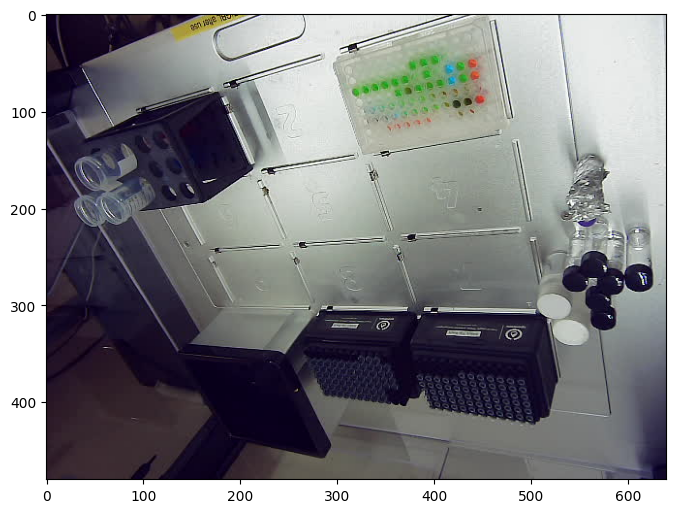

In [1]:
pic_folder = '.'  # Current folder (relative path)
# Read all the files from a specified directory
images_list=[]
# for (dirpath, dirnames, filenames) in os.walk(pic_folder):
#     for filename in filenames:
#         if filename!='.DS_Store':
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

for img in os.listdir(pic_folder):
    if img.endswith("captured_image.jpg"):
        image_path = os.path.join(pic_folder, img)
        image = Image.open(image_path, 'r')
        im = Image.fromarray(np.array(image, dtype=np.uint8), 'RGB')
        # Proceed with image processing

        # Create figure and axes
        fig,ax = plt.subplots(1,figsize=(8,8))
        # Display the image
        ax.imshow(im)
        plt.show()            
#
# test picture for adjusting the cropping box
# should try mutiple ones for the optimium cropping box options

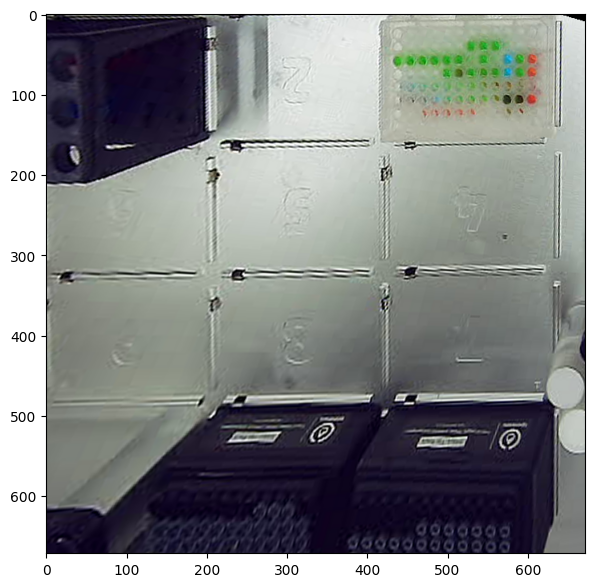

In [2]:
import numpy

def find_coeffs(pa, pb):
    matrix = []
    for p1, p2 in zip(pa, pb):
        matrix.append([p1[0], p1[1], 1, 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1]])
        matrix.append([0, 0, 0, p1[0], p1[1], 1, -p2[1]*p1[0], -p2[1]*p1[1]])

    A = numpy.matrix(matrix, dtype=float)  # <-- fixed here
    B = numpy.array(pb).reshape(8)

    res = numpy.dot(numpy.linalg.inv(A.T * A) * A.T, B)
    return numpy.array(res).reshape(8)

img = image
width, height = img.size
m = -0.1
n = 0.1
xshift = abs(m) * width
yshift = abs(n) * height
new_width = width + int(round(xshift))
new_height = height +int(round(yshift))
final_coeffs = [(94, 101), (460, 0), (520, 309), (196, 301)]  # Start with current
final_crop = (431, 14, 608, 150)
coeffs = find_coeffs(
        [(0, 0), (640, 0), (640, 480), (0, 480)],
        final_coeffs)

img_corr = img.transform((int(width*1.05), int(height*1.4)), Image.PERSPECTIVE, coeffs, Image.BICUBIC)

# Create figure and axes
fig,ax = plt.subplots(1,figsize=(7,7))
# Display the image
ax.imshow(img_corr)
plt.show()

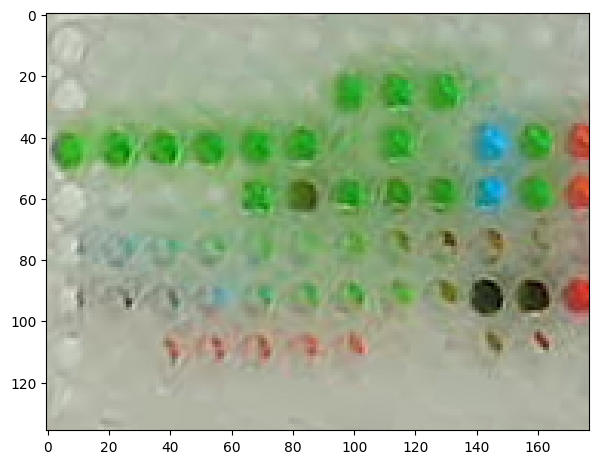

In [3]:
crop_box= final_crop 
image_cropped = img_corr.crop(box=crop_box) #box=(left, upper, right, lower)

# Create figure and axes
fig,ax = plt.subplots(1,figsize=(7,7))
# Display the image
ax.imshow(image_cropped)
plt.show()

In [4]:
import matplotlib.patches as patches

def get_image_array(image, crop_box):
    """Get a numpy array of an image so that one can access values[x][y]."""
    image = image.crop(box=crop_box) #box=(left, upper, right, lower)
    [width,height] = image.size
    pixel_values = list(image.getdata())
    if image.mode == 'RGB':
        channels = 3
    elif image.mode == 'L':
        channels = 1
    else:
        print("Unknown mode: %s" % image.mode)
        return None
    pixel_values = np.array(pixel_values).reshape((height, width, channels))
    return (width,height,pixel_values)

def image_slicing(image_array, col_num,row_num, offset_array):
    """slice the ROIs from an image of an array of samples/colorcard"""
    row_h = int(np.round(image_array.shape[0]/row_num))
    col_w = int(np.round(image_array.shape[1]/col_num))
    
    fig,ax = plt.subplots(1,figsize=(8,8))
    images = []
    imagecol = []
    for y in np.arange(row_num):
        imagerow = []
        for x in np.arange(col_num):
            # slicing indices for each color square
            y1 = row_h*y+offset_array[1][0]
            y2 = row_h*(y+1)-offset_array[1][1]
            x1 = col_w*x+offset_array[0][0]
            x2 = col_w*(x+1)-offset_array[0][1]
            image = image_array[y1:y2,x1:x2]
            imagerow.append(image)#append every images in a row into a row list
            images.append(image)#append every images into a list
            # Add the rectangular patch to the Axes
            # Create a Rectangle patch
            lw=1 # Line width
            ec='r' # edge color
            fc='none' # face color
            rect = patches.Rectangle((x1,y1),x2-x1,y2-y1,
                                      linewidth=lw,edgecolor=ec,facecolor=fc)
            ax.add_patch(rect)
    
        imagecol.append(np.concatenate(imagerow, axis=1))
    image_reconstr = np.array(np.concatenate(imagecol, axis=0), dtype=np.uint8)

    return [fig, ax, image_reconstr, images]


/var/folders/sv/vrr7b1q96js0n9_h6zt1sc200000gn/T/ipykernel_49318/3300536191.py:10: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  ax_ROI.imshow(Image.fromarray(np.array(image_array, dtype=np.uint8), 'RGB'))


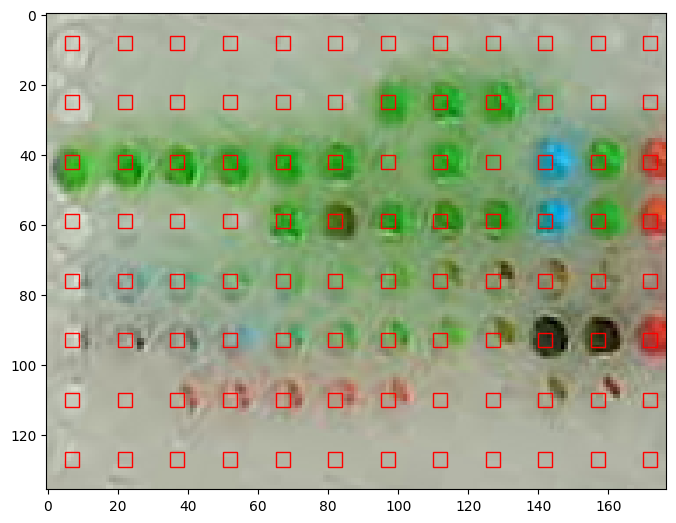

In [5]:
w, h, image_array = get_image_array(img_corr, crop_box)
              
# Row, Columns Settings and Offset pixels for each sample (TO BE CHANGED)
row_num=8
col_num=12
offset_array= [[5,6],[6,7]]#[[x_left,x_right],[y_upper,y_lower]]
########%%%%%%%%%%%%%%%%%%%%%%%%###############
[fig_ROI, ax_ROI, reconstr_ROI, image_ROI]= image_slicing(
        image_array, col_num, row_num, offset_array)
ax_ROI.imshow(Image.fromarray(np.array(image_array, dtype=np.uint8), 'RGB'))
fig_ROI.savefig(os.path.join(pic_folder, "reconstructed_with_boxes.jpg"))
plt.show()

from PIL import Image


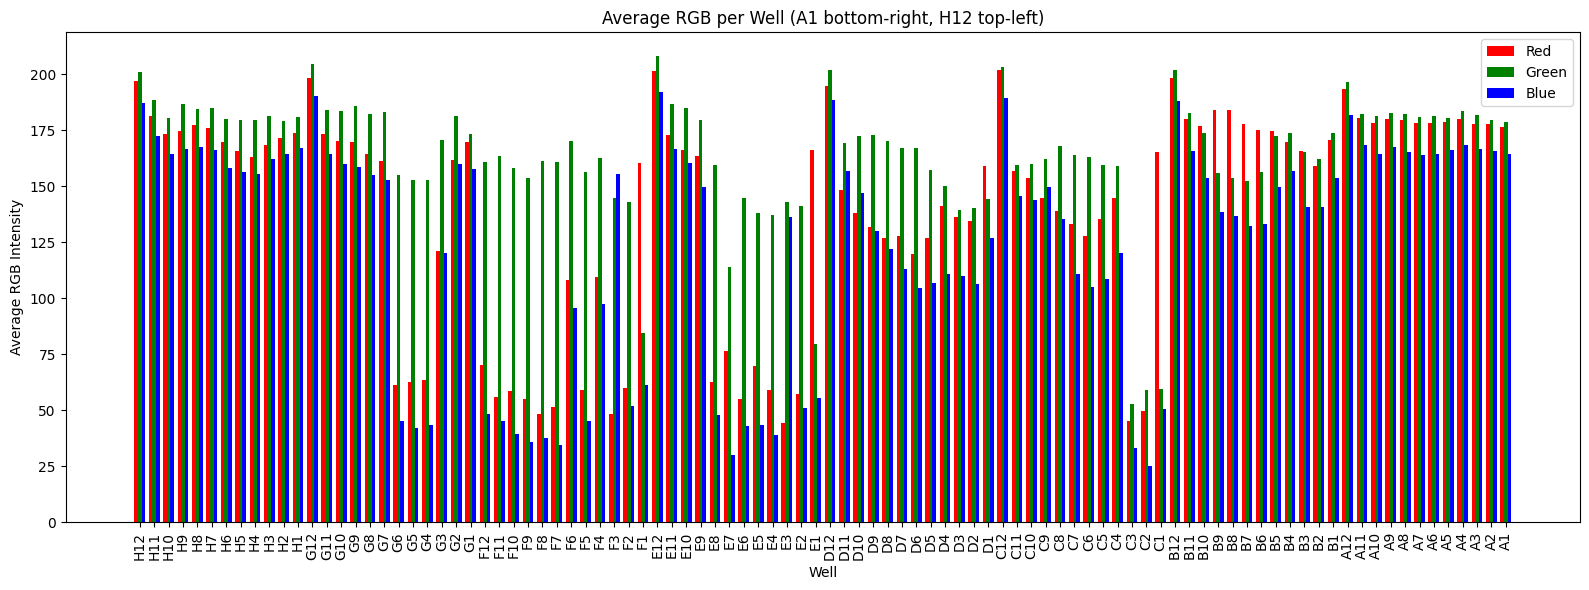

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# image_ROI is a list of numpy arrays from Part 12 (shape ~ [h,w,3])
# Map wells so that:
# - bottom-right is A1
# - bottom second-right is A2
# - second last row right is B1
# - top-left is H12
# image_slicing produced ROIs row-major from top-left to bottom-right:
#   row index y: 0..7 (top..bottom), col index x: 0..11 (left..right)
# We'll compute index -> (row, col) -> well name per the requested orientation.

rows = 8
cols = 12
row_letters = list("ABCDEFGH")  # A..H

# Compute average RGBs and build well names in requested orientation
avg_rgbs = []
well_names = []

for idx, roi in enumerate(image_ROI):
    y = idx // cols            # 0 top .. 7 bottom
    x = idx % cols             # 0 left .. 11 right

    # Requested orientation mapping
    row_letter = row_letters[(rows - 1) - y]     # bottom->top maps to A..H
    col_number = (cols - x)                      # right->left maps to 1..12

    well_name = f"{row_letter}{col_number}"
    well_names.append(well_name)

    rgb_avg = np.mean(np.array(roi), axis=(0, 1))  # [R,G,B]
    avg_rgbs.append(rgb_avg)

avg_rgbs = np.array(avg_rgbs)
r_vals = avg_rgbs[:, 0]
g_vals = avg_rgbs[:, 1]
b_vals = avg_rgbs[:, 2]

# Bar plot labeled with well names
x = np.arange(len(image_ROI))
width = 0.25

fig, ax = plt.subplots(figsize=(16, 6))
ax.bar(x - width, r_vals, width, color='red', label='Red')
ax.bar(x,         g_vals, width, color='green', label='Green')
ax.bar(x + width, b_vals, width, color='blue', label='Blue')

ax.set_xlabel("Well")
ax.set_ylabel("Average RGB Intensity")
ax.set_title("Average RGB per Well (A1 bottom-right, H12 top-left)")
ax.set_xticks(x)
ax.set_xticklabels(well_names, rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

# For convenience, also expose a dict mapping well -> RGB
well_to_rgb = {name: avg_rgbs[i].tolist() for i, name in enumerate(well_names)}


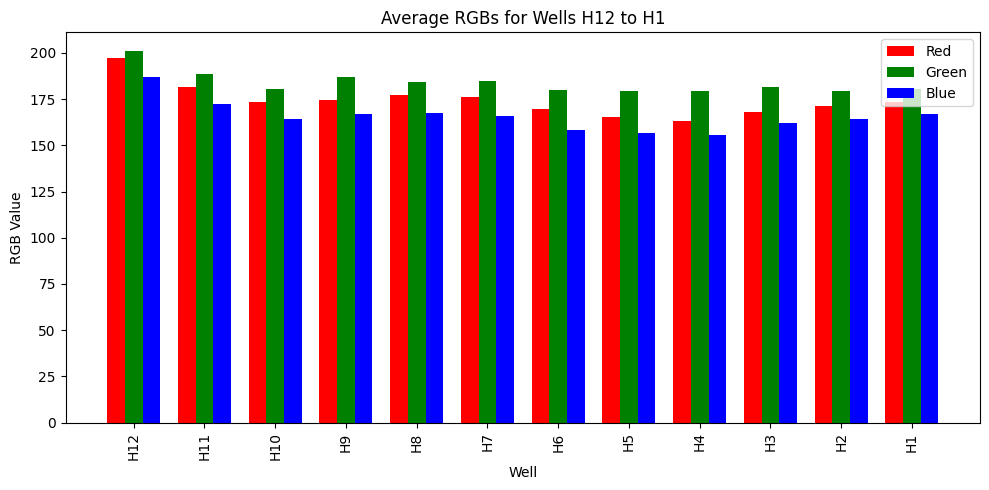

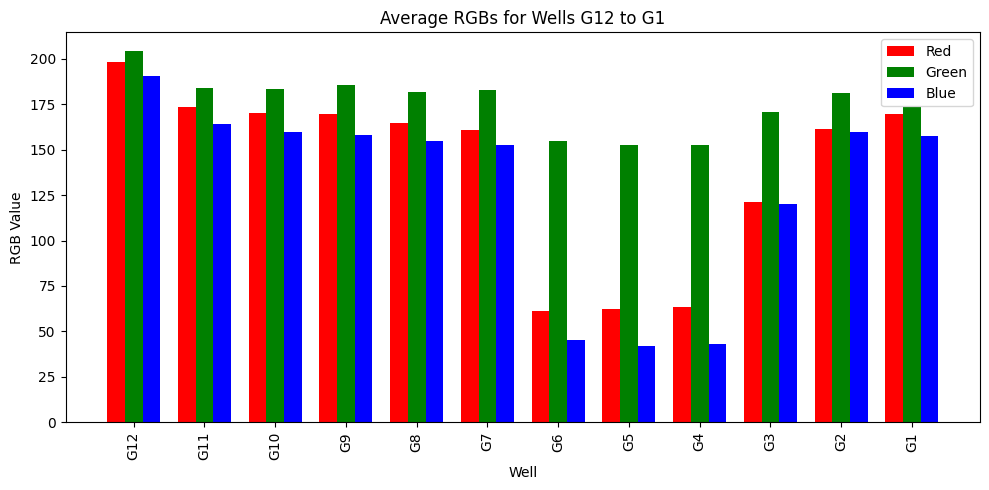

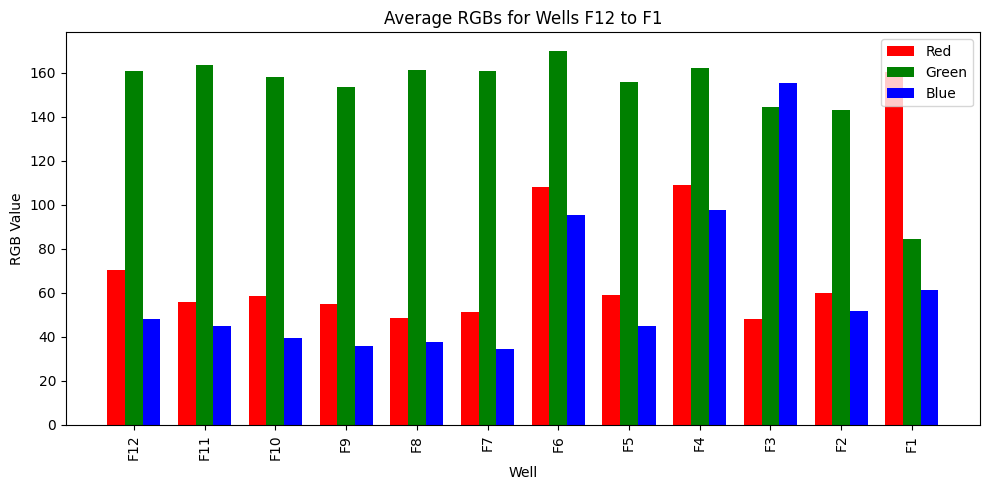

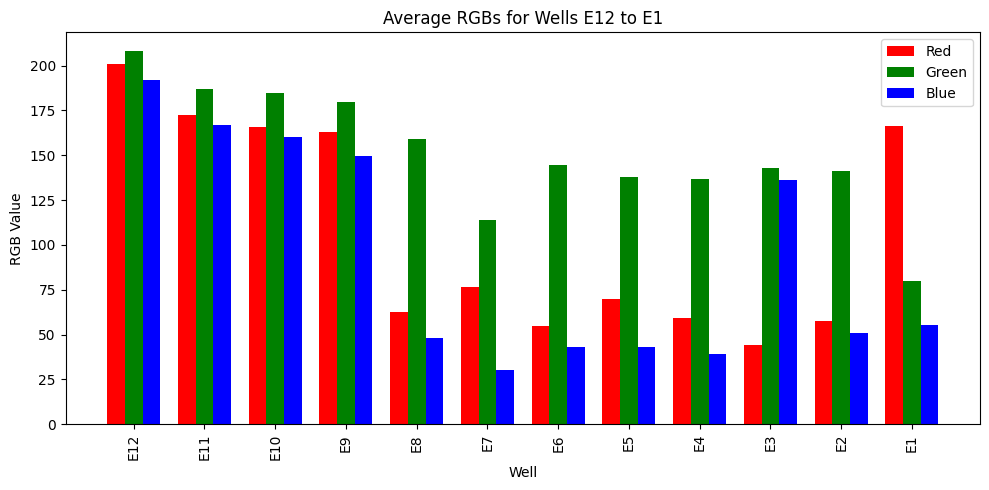

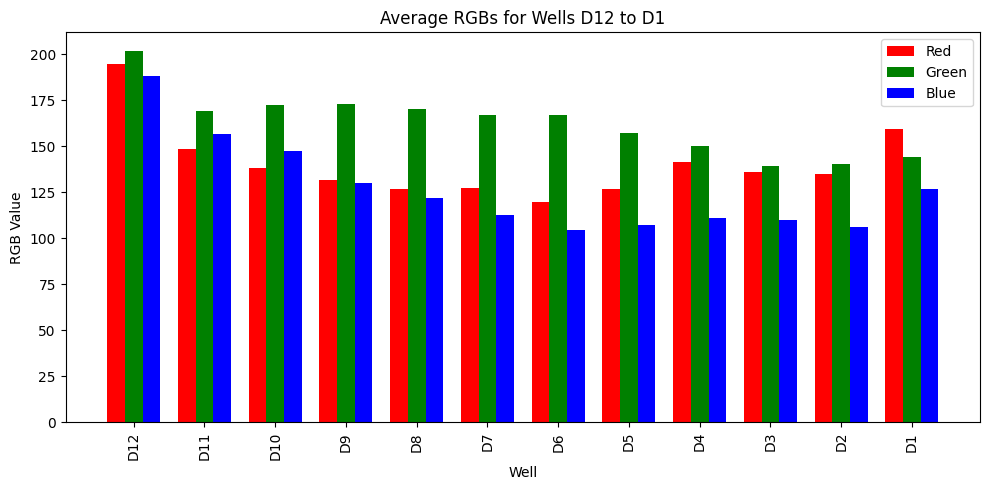

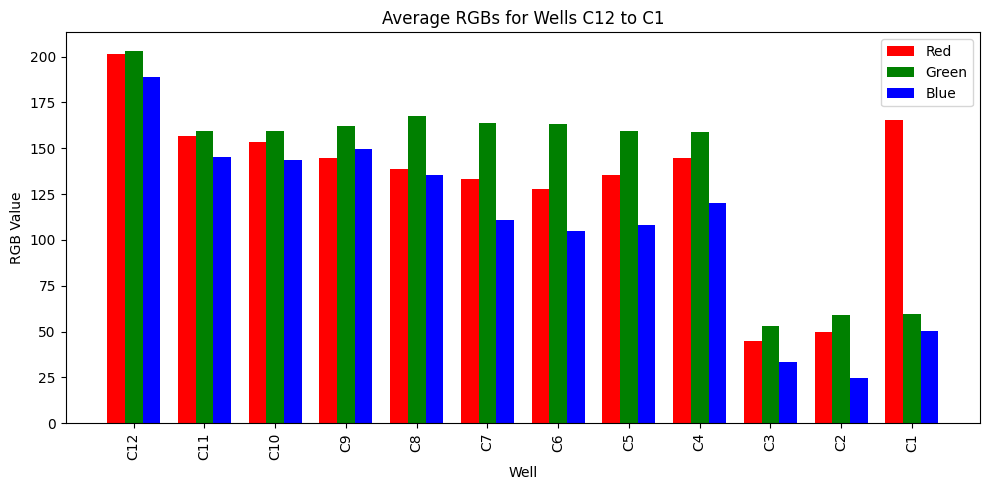

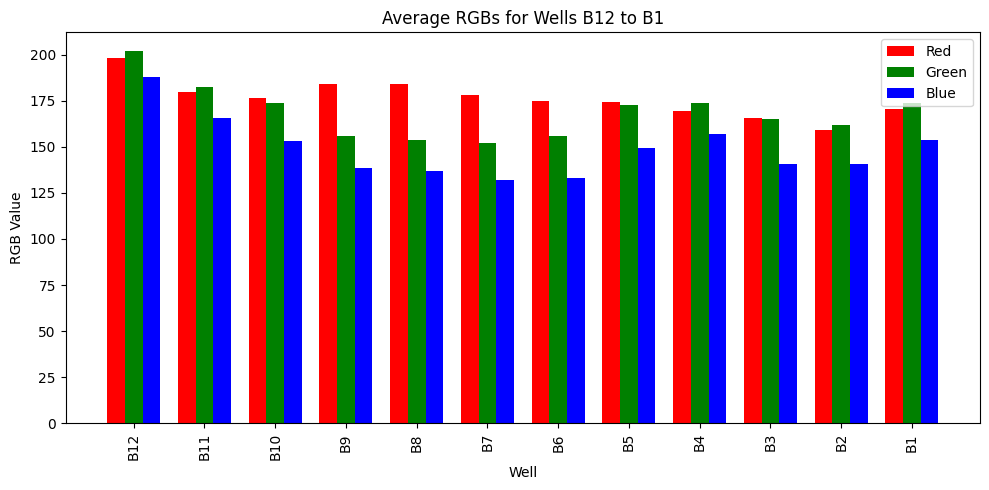

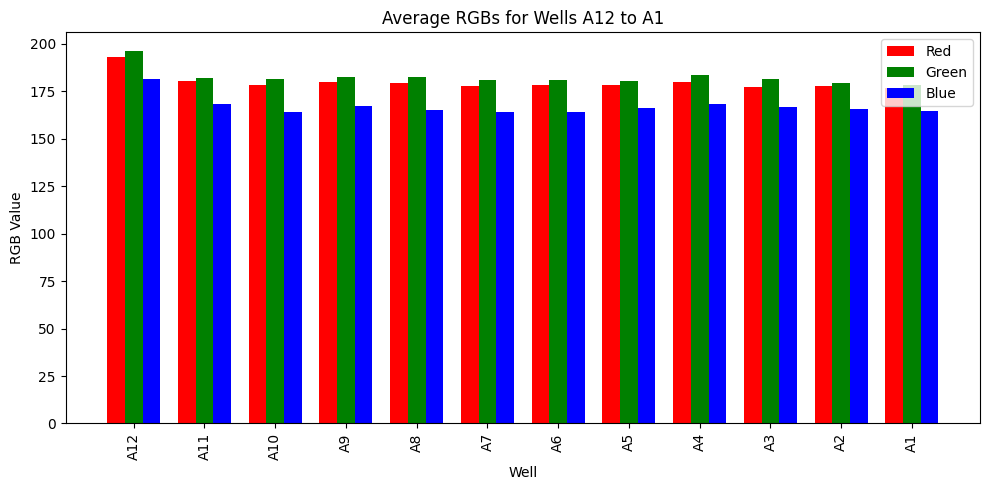

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Use avg_rgbs and well_names computed in the previous cell (Part 12b)
# avg_rgbs: numpy array of shape (96, 3)
# well_names: list of 96 strings like ["A1", ..., "H12"] according to requested orientation

# --- Plot in chunks for readability ---
def plot_rgb_chunks(avg_rgbs, well_names, chunk_size=10):
    num_chunks = int(np.ceil(len(avg_rgbs) / chunk_size))

    for c in range(num_chunks):
        start = c * chunk_size
        end = min((c + 1) * chunk_size, len(avg_rgbs))
        chunk = avg_rgbs[start:end]
        labels = well_names[start:end]

        r_vals = chunk[:, 0]
        g_vals = chunk[:, 1]
        b_vals = chunk[:, 2]
        x = np.arange(len(chunk))
        width = 0.25

        fig, ax = plt.subplots(figsize=(10, 5))
        ax.bar(x - width, r_vals, width, color='red', label='Red')
        ax.bar(x,         g_vals, width, color='green', label='Green')
        ax.bar(x + width, b_vals, width, color='blue', label='Blue')

        ax.set_title(f"Average RGBs for Wells {labels[0]} to {labels[-1]}")
        ax.set_xlabel("Well")
        ax.set_ylabel("RGB Value")
        ax.set_xticks(x)
        ax.set_xticklabels(labels, rotation=90)
        ax.legend()
        plt.tight_layout()
        plt.show()

# --- Call the function with labeled wells ---
plot_rgb_chunks(avg_rgbs, well_names, chunk_size=12)


In [17]:
# Extract RGB values of F1, F2, F3, F5, F7, F8, F9, F10, F11 and F12
rgb_F1 = well_to_rgb.get("F1")
rgb_F2 = well_to_rgb.get("F2")
rgb_F3 = well_to_rgb.get("F3")
rgb_F5 = well_to_rgb.get("F5")
rgb_F7 = well_to_rgb.get("F7")
rgb_F8 = well_to_rgb.get("F8")
rgb_F9 = well_to_rgb.get("F9")
rgb_F10 = well_to_rgb.get("F10")
rgb_F11 = well_to_rgb.get("F11")
rgb_F12 = well_to_rgb.get("F12")

print("Red - Input 1:", rgb_F1)
print("Green - Input 2:", rgb_F2)
print("Blue - Input 3:", rgb_F3)
print("Run 1:", rgb_F5)
print("Run 2:", rgb_F7)
print("Run 3:", rgb_F8)
print("Run 4:", rgb_F9)
print("Run 5:", rgb_F10)
print("Run 6:", rgb_F11)
print("Run 7:", rgb_F12)

# Optionally, group into one array
selected_rgbs = np.array([rgb_F1, rgb_F2, rgb_F3, rgb_F5, rgb_F7, rgb_F8, rgb_F9, rgb_F10, rgb_F11, rgb_F12])
print("Selected basis RGBs:", selected_rgbs)


Red - Input 1: [160.375, 84.625, 61.375]
Green - Input 2: [60.0625, 143.0, 51.875]
Blue - Input 3: [48.3125, 144.5625, 155.25]
Run 1: [59.1875, 156.0625, 45.0]
Run 2: [51.4375, 160.8125, 34.625]
Run 3: [48.4375, 161.125, 37.625]
Run 4: [54.875, 153.75, 35.875]
Run 5: [58.625, 158.25, 39.4375]
Run 6: [55.75, 163.375, 45.0625]
Run 7: [70.3125, 160.875, 48.375]
Selected basis RGBs: [[160.375   84.625   61.375 ]
 [ 60.0625 143.      51.875 ]
 [ 48.3125 144.5625 155.25  ]
 [ 59.1875 156.0625  45.    ]
 [ 51.4375 160.8125  34.625 ]
 [ 48.4375 161.125   37.625 ]
 [ 54.875  153.75    35.875 ]
 [ 58.625  158.25    39.4375]
 [ 55.75   163.375   45.0625]
 [ 70.3125 160.875   48.375 ]]


RGB values:
Input 1: [160.375, 84.625, 61.375]
Input 2: [60.0625, 143.0, 51.875]
Input 3: [48.3125, 144.5625, 155.25]
Run 1: [59.1875, 156.0625, 45.0]
Run 2: [51.4375, 160.8125, 34.625]
Run 3: [48.4375, 161.125, 37.625]
Run 4: [54.875, 153.75, 35.875]
Run 5: [58.625, 158.25, 39.4375]
Run 6: [55.75, 163.375, 45.0625]
Run 7: [70.3125, 160.875, 48.375]


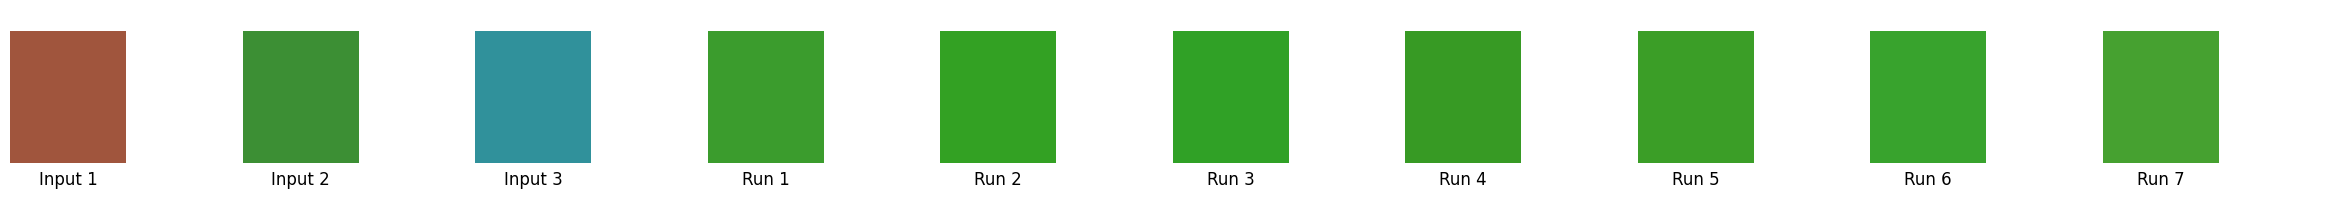

In [31]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

rgb_F1 = well_to_rgb.get("F1")
rgb_F2 = well_to_rgb.get("F2")
rgb_F3 = well_to_rgb.get("F3")
rgb_F5 = well_to_rgb.get("F5")
rgb_F7 = well_to_rgb.get("F7")
rgb_F8 = well_to_rgb.get("F8")
rgb_F9 = well_to_rgb.get("F9")
rgb_F10 = well_to_rgb.get("F10")
rgb_F11 = well_to_rgb.get("F11")
rgb_F12 = well_to_rgb.get("F12")


selected = {
    "Input 1": rgb_C1,
    "Input 2": rgb_C2,
    "Input 3": rgb_C3,
    "Run 1": rgb_F5,
    "Run 2": rgb_F7,
    "Run 3": rgb_F8,
    "Run 4": rgb_F9,
    "Run 5": rgb_F10,
    "Run 6": rgb_F11,
    "Run 7": rgb_F12
    
}

print("RGB values:")
for well, rgb in selected.items():
    print(f"{well}: {rgb}")

# --- Plot swatches ---
fig, ax = plt.subplots(figsize=(30, 2))

swatch_size = 3.0   # width/height of each swatch
gap = 3          # spacing between swatches

for i, (well, rgb) in enumerate(selected.items()):
    color = np.array(rgb) / 255.0
    x_pos = i * (swatch_size + gap)  # apply spacing
    rect = Rectangle((x_pos, 0), swatch_size, swatch_size, facecolor=color)
    ax.add_patch(rect)
    
    # well label below
    ax.text(x_pos + swatch_size/2, -0.15, well, ha="center", va="top", fontsize=12)
    

ax.set_xlim(0, len(selected) * (swatch_size + gap))
ax.set_ylim(0, swatch_size + 0.5)
ax.axis("off")
plt.show()


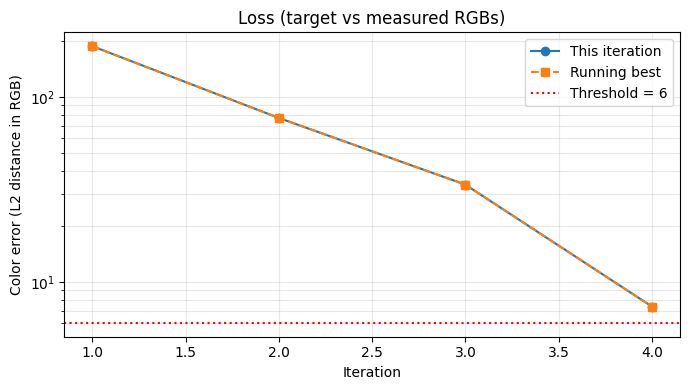

Errors per iteration: [188.21530225  76.97402159  33.54101966   7.34846923]
Cumulative best: [188.21530225  76.97402159  33.54101966   7.34846923]


In [40]:
import numpy as np
import matplotlib.pyplot as plt

def plot_loss_from_rgbs(measured_rgbs, target_rgb, error_threshold=None, logy=True):
    """
    measured_rgbs: list of RGB triplets (e.g. [(120, 80, 50), (100, 90, 60), ...])
    target_rgb:    single RGB triplet (e.g. (55, 150, 40))
    error_threshold: optional float to draw a horizontal line
    logy: whether to use log-scale for y-axis
    """
    # convert to np arrays
    target = np.array(target_rgb, dtype=float)
    measured = np.array(measured_rgbs, dtype=float)

    # compute errors (L2 distance)
    errors = np.linalg.norm(measured - target, axis=1)

    # running best (cumulative minimum)
    cum_best = np.minimum.accumulate(errors)

    # iteration indices
    iters = np.arange(1, len(errors) + 1)

    plt.figure(figsize=(7,4))
    plt.plot(iters, errors, marker='o', label='This iteration')
    plt.plot(iters, cum_best, marker='s', linestyle='--', label='Running best')

    if error_threshold is not None:
        plt.axhline(error_threshold, color='r', linestyle=':', label=f'Threshold = {error_threshold}')

    if logy:
        plt.yscale('log')

    plt.xlabel("Iteration")
    plt.ylabel("Color error (L2 distance in RGB)")
    plt.title("Loss (target vs measured RGBs)")
    plt.grid(True, which='both', alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return errors, cum_best

# --- Example usage ---
target_rgb = (55, 150, 40)
measured_rgbs = [
    (200, 30, 40),
    (120, 110, 50),
    (80, 140, 60),
    (60, 145, 42)
]

errors, cum_best = plot_loss_from_rgbs(measured_rgbs, target_rgb, error_threshold=6)
print("Errors per iteration:", errors)
print("Cumulative best:", cum_best)
